In [1]:
!pip install pyodbc
!pip install pymysql


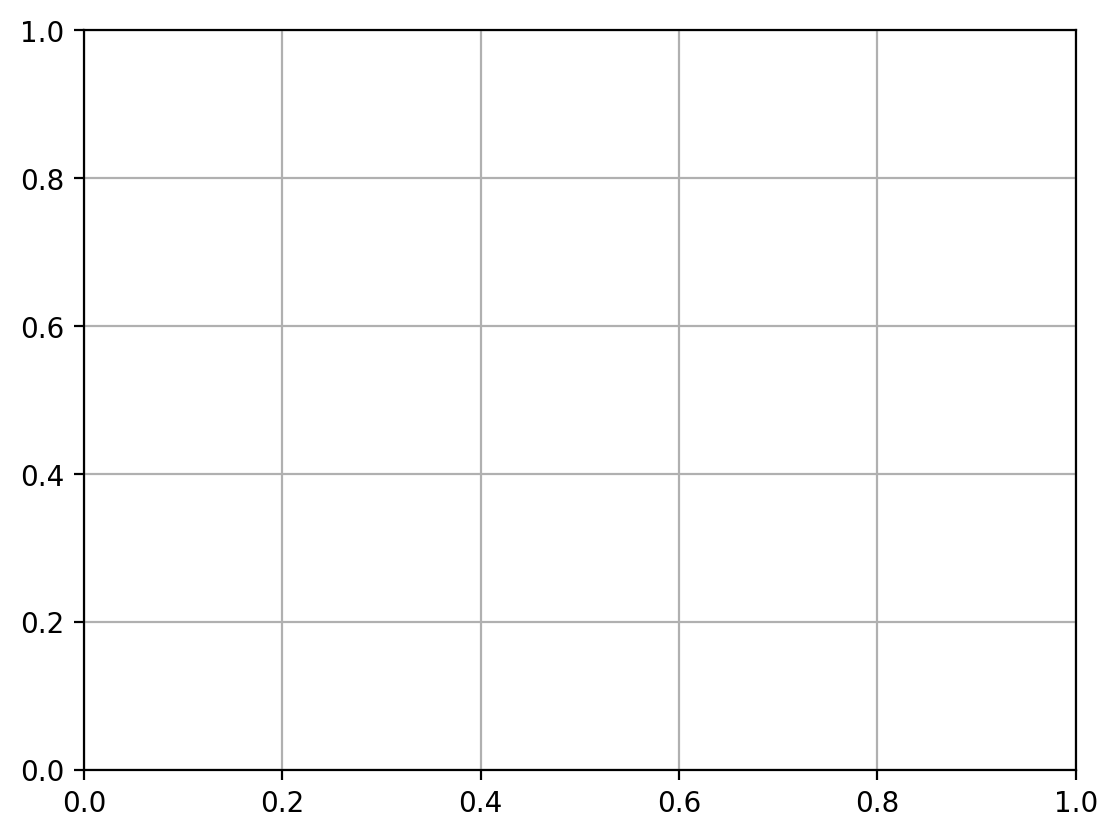

In [2]:
"""Imports"""
from calendar import month
from ctypes import c_ulong
import pandas as pd
from pandas import DataFrame
import pandas.io.sql as psql
import numpy as np
import re
import chainladder as cl
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import ipywidgets as widgets
from dateutil import relativedelta as rd
import datetime
import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
import sqlite3
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-deep')
plt.grid(None)
%config InlineBackend.figure_format = 'retina'
from sklearn.metrics import r2_score
from sqlalchemy import create_engine, URL
import pyodbc
import pymysql
import pymysql.cursors


In [3]:
""""connect to SQL Server"""

server = 'arm-sql1.database.windows.net'
database = 'Unified' 
username = 'joranias' 
password = 'dataread!!!@12'

connection_string = (
    "Driver={ODBC Driver 17 for SQL Server};"
    f"Server=arm-sql1.database.windows.net;Database={database};uid={username};pwd={password}"
)

connection_url = URL.create(
            "mssql+pyodbc", query={"odbc_connect": connection_string})

# Create an engine and connect
engine = create_engine(connection_url)

try:
    with engine.connect() as connection:
        print("Connection successful!")
except Exception as e:
    print(f"Error: {e}")


Connection successful!


In [4]:
"""Read Claims Data"""
query_claims= "select * from harmonized.t_Claims_Data_For_IBNP_Calculation"

df = pd.read_sql_query(query_claims, engine)

"""Read Premium Data"""
query_premiums= "select * from harmonized.t_Premium_Data_For_IBNP_Calculation"

pf = pd.read_sql_query(query_premiums, engine)

"""Read Loss Ratio Input"""
query_loss_ratios= "select* from rates.Loss_Ratios_For_IBNP_Calculation"
lr_input=pd.read_sql_query(query_loss_ratios, engine)



In [5]:
"""premium triangle"""

pf['ValuationDate']='2024-03-31'

InputOriginP='Valuation_Date'
InputDevelopmentP='ValuationDate'
InputColumnsP='Annualized_Premium'
InputCumulativeP=True
InputCompanyP="Client_ID"
#InputBlockP="block_code"
#InputPLOBP="PLOB"
#InputLOBP="LOB"
#InputStateP="State"

wep = cl.Triangle(
    pf,
    origin=InputOriginP,
    development=InputDevelopmentP,
    columns=InputColumnsP,
    index=[InputCompanyP],
    cumulative=InputCumulativeP
)

wep

c:\Users\joranias\AppData\Local\anaconda3\envs\Py311\Lib\site-packages\chainladder\core\base.py:106: UserWarning: 
                Observations with development before
                origin start have been removed.
  warnings.warn(


,Triangle Summary
Valuation:,2024-03
Grain:,OMDM
Shape:,"(18, 1, 39, 1)"
Index:,[Client_ID]
Columns:,[Annualized_Premium]


In [6]:
""" Compnay_ID List"""
"""FALTAN LOS DOS QUE NO SE DONDE ASOCIAR"""

Company_ID_List=['ASL','AMH','GBR','GTL','NFL','NSL','PEN','PHS', 'PRT','SLI','ULI','USH', 'XCH']

company_id={}

for n in Company_ID_List:
    company_id= n

    print(company_id)

ASL
AMH
GBR
GTL
NFL
NSL
PEN
PHS
PRT
SLI
ULI
USH
XCH


In [7]:

"""set the cumulative 24 months triangle and process for each client"""

ValuationDate= datetime.date(2024,3,31)
ValuationDate_Text=f'{ValuationDate.year}-{ValuationDate.month}-{ValuationDate.day}'
InitialDate= f'{ValuationDate.year-2}-{ValuationDate.month}-{ValuationDate.day}'

df=df[df.Paid_Date<=ValuationDate]

Premium_triangle=wep[((wep.origin>InitialDate) & (wep.origin<=ValuationDate_Text))]


triangle_var={}
triangle_cum={}
triangle_cum_df={}
triangle_factors={}
triangle_factors_df={}
EarnedPremium={}
EarnedPremium_df={}
LossRatio={}
LossRatio_1={}
LossRatio_2={}
LossRatio_3={}
transformed_triangleVolumeAll={}
ldfVolumeAll={}
cdfVolumeAll={}
cdfVolumeAll_df={}
transformed_triangleVolume12={}
ldfVolume12={}
cdfVolume12={}
cdfVolume12_df={}
transformed_triangleVolume6={}
ldfVolume6={}
cdfVolume6={}
cdfVolume6_df={}
transformed_triangleVolume3={}
ldfVolume3={}
cdfVolume3={}
cdfVolume3_df={}  
transformed_triangleSimpleAll={}
ldfSimpleAll={}
cdfSimpleAll={}
cdfSimpleAll_df={}
transformed_triangleSimple12={}
ldfSimple12={}
cdfSimple12={}
cdfSimple12_df={}
transformed_triangleSimple6={}
ldfSimple6={}
cdfSimple6={}
cdfSimple6_df={}
transformed_triangleSimple3={}
ldfSimple3={}
cdfSimple3={}
cdfSimple3_df={}

ldfInitialSelected={}
cdfInitialSelected={}
ldfInitialSelected_df={}
cdfInitialSelected_df={}

triangle={}
OutlierLimit={}
df_lim={}
we_lim={}

OutlierLimit['ASL']=10000000
OutlierLimit['AMH']=10000000
OutlierLimit['GBR']=10000000
OutlierLimit['GTL']=10000000
OutlierLimit['NFL']=10000000
OutlierLimit['NSL']=10000000
OutlierLimit['PEN']=10000000
OutlierLimit['PHS']=10000000
OutlierLimit['PRT']=10000000
OutlierLimit['SLI']=10000000
OutlierLimit['ULI']=10000000
OutlierLimit['USH']=10000000
OutlierLimit['XCH']=10000000


for n in Company_ID_List:

   df_lim[n]=df[(df.Claim_Amount<OutlierLimit[n]) & (df.Claim_Amount>-OutlierLimit[n])]

   InputOrigin='Incurred_Date'
   InputDevelopment='Paid_Date'
   InputColumns='Claim_Amount'
   InputCumulative=False
   InputCompany="Company_ID"
   #InputBlock="Block_ID"
   #InputLOB="Line_Of_Business"


   we_lim[n] = cl.Triangle(
      df_lim[n],
      origin=InputOrigin,
      development=InputDevelopment,
      columns=InputColumns,
      index=[InputCompany],
      cumulative=InputCumulative
   )


   triangle[n]=we_lim[n][((we_lim[n].origin>InitialDate) & (we_lim[n].origin<=ValuationDate_Text))][we_lim[n].development<25]
   triangle_var[n]=triangle[n].loc[n]  
   triangle_cum[n] = triangle_var[n].incr_to_cum()
   triangle_cum_df[n]=triangle_cum[n].to_frame()
   
   triangle_factors[n] = triangle_cum[n].link_ratio
   triangle_factors_df[n]=triangle_factors[n].to_frame()
   
   EarnedPremium[n]= Premium_triangle.loc[n]/12
   EarnedPremium_df[n]=EarnedPremium[n].to_frame()

   LossRatio[n]=lr_input[lr_input.Client_ID==n]
   LossRatio_1[n]=LossRatio[n].Month_Minus_1.to_frame()
   LossRatio_2[n]=LossRatio[n].Month_Minus_2.to_frame()
   LossRatio_3[n]=LossRatio[n].Month_Minus_3.to_frame()

   #Different Averages n
   VolumeAll=cl.Development(average='volume',n_periods=24)
   transformed_triangleVolumeAll[n]= VolumeAll.fit_transform(triangle_cum[n])
   ldfVolumeAll[n]=transformed_triangleVolumeAll[n].ldf_
   cdfVolumeAll[n]=transformed_triangleVolumeAll[n].cdf_
   cdfVolumeAll_df[n]=(1/cdfVolumeAll[n]).T

   Volume12=cl.Development(average='volume',n_periods=12)
   transformed_triangleVolume12[n]= Volume12.fit_transform(triangle_cum[n])
   ldfVolume12[n]=transformed_triangleVolume12[n].ldf_
   cdfVolume12[n]=transformed_triangleVolume12[n].cdf_
   cdfVolume12_df[n]=(1/cdfVolume12[n]).T

   Volume6=cl.Development(average='volume',n_periods=6)
   transformed_triangleVolume6[n]= Volume6.fit_transform(triangle_cum[n])
   ldfVolume6[n]=transformed_triangleVolume6[n].ldf_
   cdfVolume6[n]=transformed_triangleVolume6[n].cdf_
   cdfVolume6_df[n]=(1/cdfVolume6[n]).T

   Volume3=cl.Development(average='volume',n_periods=3)
   transformed_triangleVolume3[n]= Volume3.fit_transform(triangle_cum[n])
   ldfVolume3[n]=transformed_triangleVolume3[n].ldf_
   cdfVolume3[n]=transformed_triangleVolume3[n].cdf_
   cdfVolume3_df[n]=(1/cdfVolume3[n]).T
   
   SimpleAll=cl.Development(average='simple',n_periods=24)
   transformed_triangleSimpleAll[n]= SimpleAll.fit_transform(triangle_cum[n])
   ldfSimpleAll[n]=transformed_triangleSimpleAll[n].ldf_
   cdfSimpleAll[n]=transformed_triangleSimpleAll[n].cdf_
   cdfSimpleAll_df[n]=(1/cdfSimpleAll[n]).T

   Simple12=cl.Development(average='simple',n_periods=12)
   transformed_triangleSimple12[n]= Simple12.fit_transform(triangle_cum[n])
   ldfSimple12[n]=transformed_triangleSimple12[n].ldf_
   cdfSimple12[n]=transformed_triangleSimple12[n].cdf_
   cdfSimple12_df[n]=(1/cdfSimple12[n]).T

   Simple6=cl.Development(average='simple',n_periods=6)
   transformed_triangleSimple6[n]= Simple6.fit_transform(triangle_cum[n])
   ldfSimple6[n]=transformed_triangleSimple6[n].ldf_
   cdfSimple6[n]=transformed_triangleSimple6[n].cdf_
   cdfSimple6_df[n]=(1/cdfSimple6[n]).T

   Simple3=cl.Development(average='simple',n_periods=3)
   transformed_triangleSimple3[n]= Simple3.fit_transform(triangle_cum[n])
   ldfSimple3[n]=transformed_triangleSimple3[n].ldf_
   cdfSimple3[n]=transformed_triangleSimple3[n].cdf_
   cdfSimple3_df[n]=(1/cdfSimple3[n]).T
   
   ldfInitialSelected[n]=ldfVolume12[n]
   cdfInitialSelected[n]=cdfVolume12[n]
   ldfInitialSelected_df[n]= ldfInitialSelected[n].to_frame()
   cdfInitialSelected_df[n]=1/cdfInitialSelected[n].T
  
   

c:\Users\joranias\AppData\Local\anaconda3\envs\Py311\Lib\site-packages\chainladder\core\base.py:106: UserWarning: 
                Observations with development before
                origin start have been removed.
  warnings.warn(
c:\Users\joranias\AppData\Local\anaconda3\envs\Py311\Lib\site-packages\chainladder\core\base.py:106: UserWarning: 
                Observations with development before
                origin start have been removed.
  warnings.warn(
c:\Users\joranias\AppData\Local\anaconda3\envs\Py311\Lib\site-packages\chainladder\core\base.py:106: UserWarning: 
                Observations with development before
                origin start have been removed.
  warnings.warn(
c:\Users\joranias\AppData\Local\anaconda3\envs\Py311\Lib\site-packages\chainladder\core\base.py:106: UserWarning: 
                Observations with development before
                origin start have been removed.
  warnings.warn(
c:\Users\joranias\AppData\Local\anaconda3\envs\Py311\Lib\site-packag

c:\Users\joranias\AppData\Local\anaconda3\envs\Py311\Lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


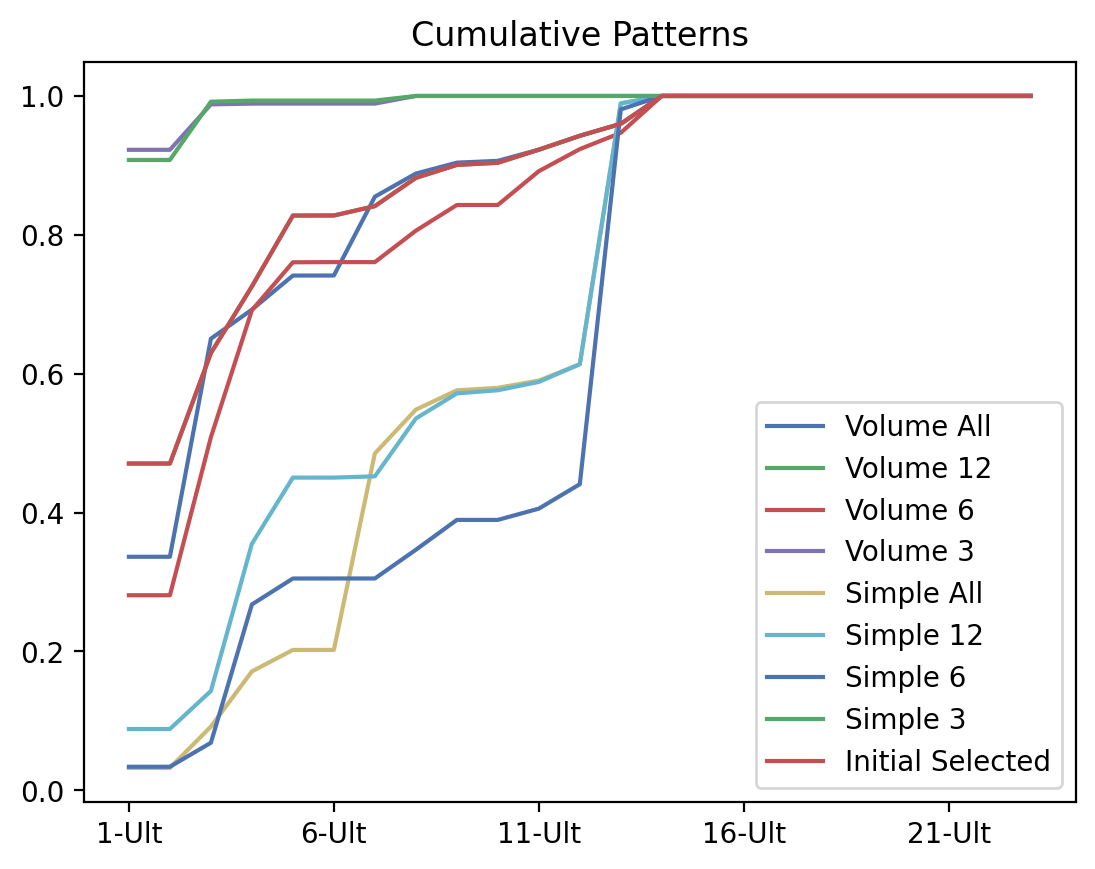

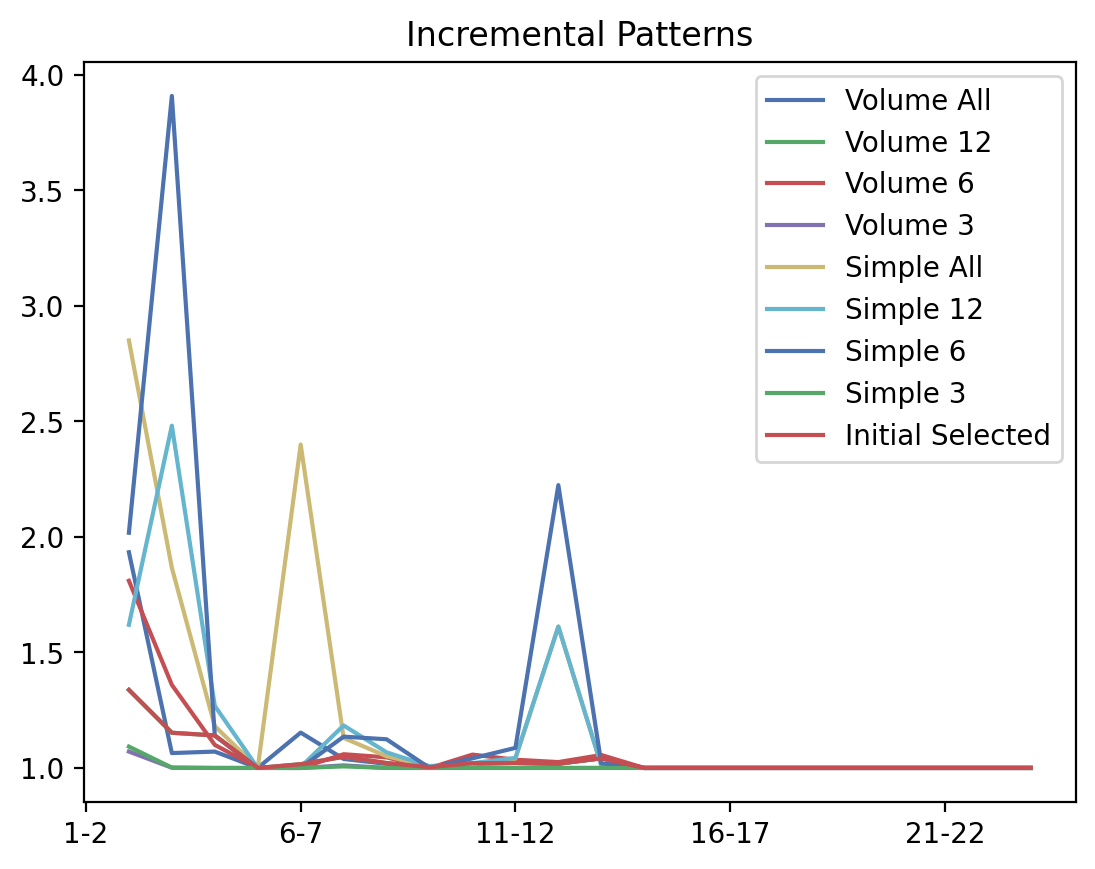

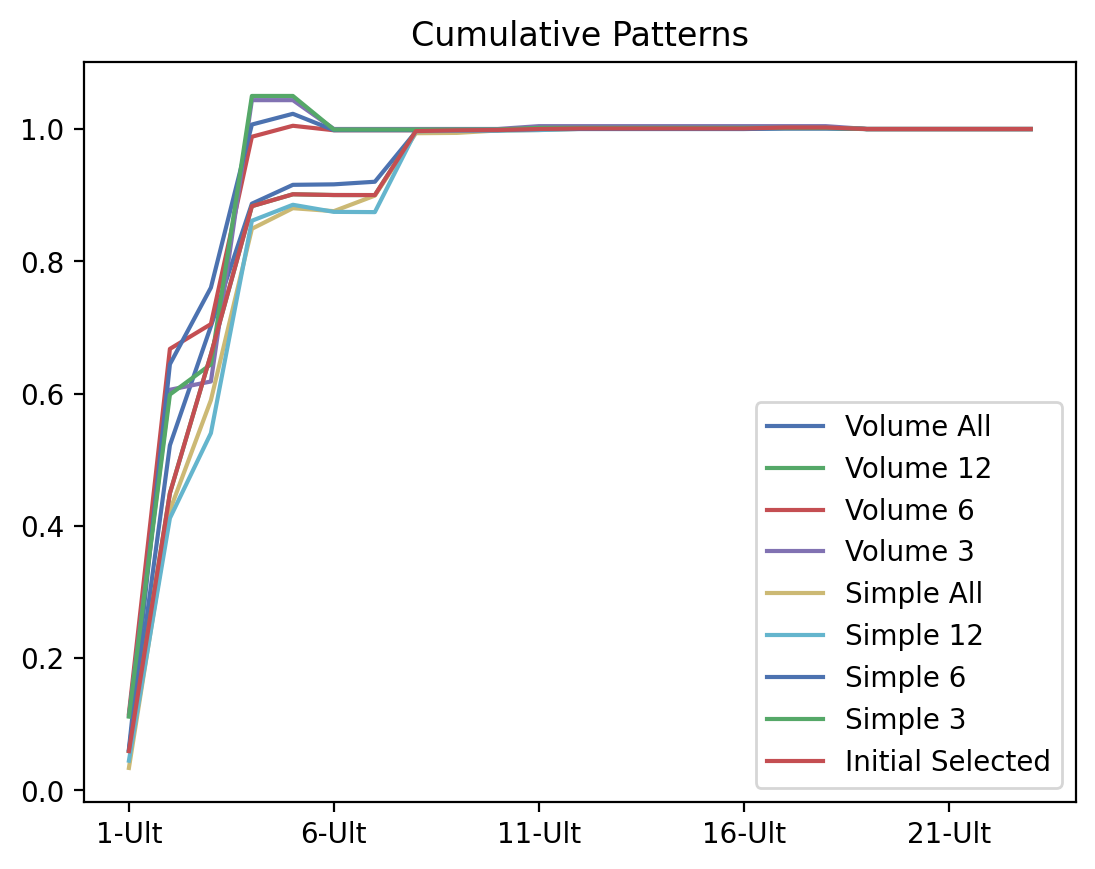

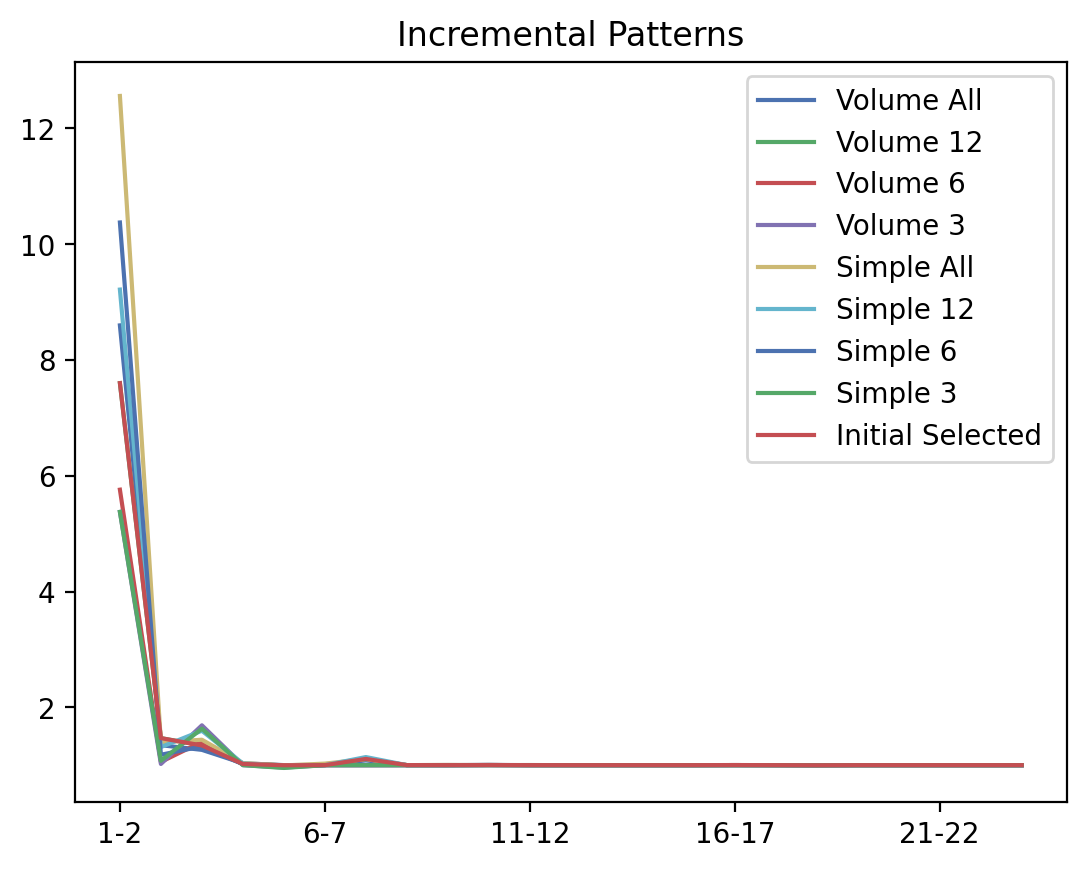

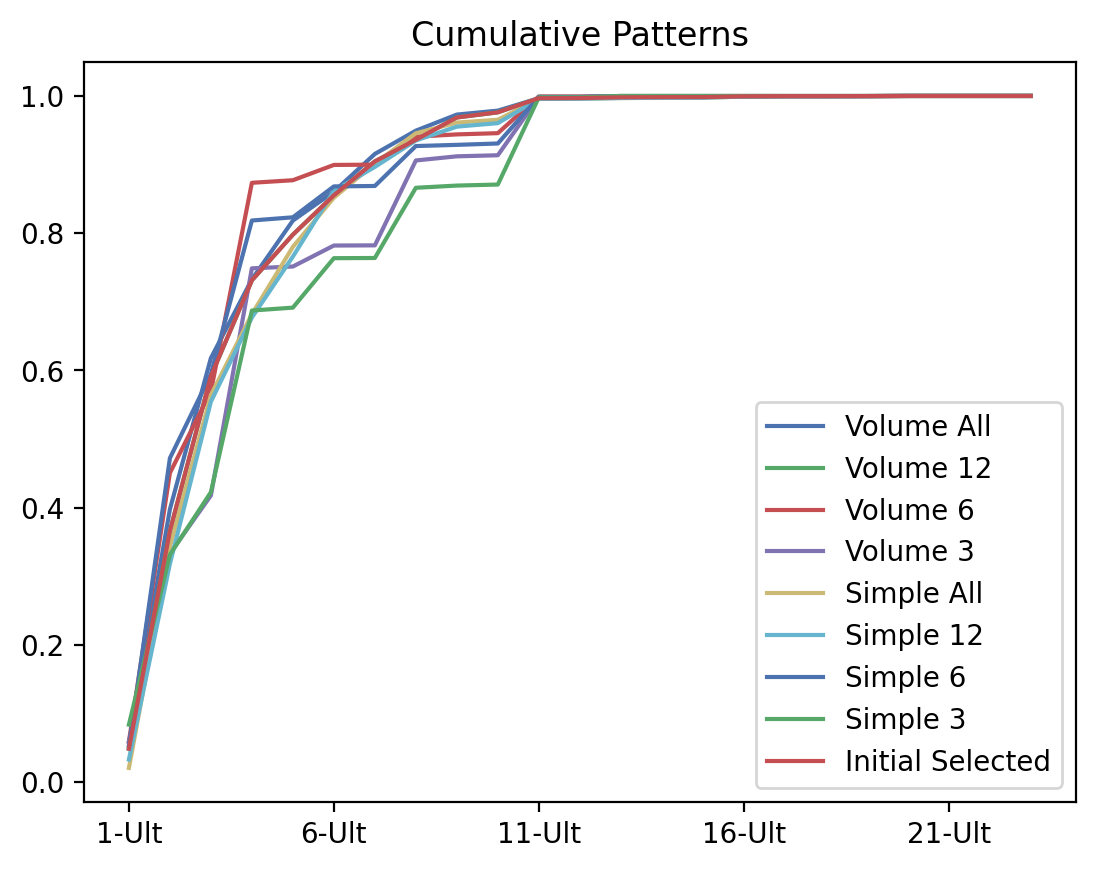

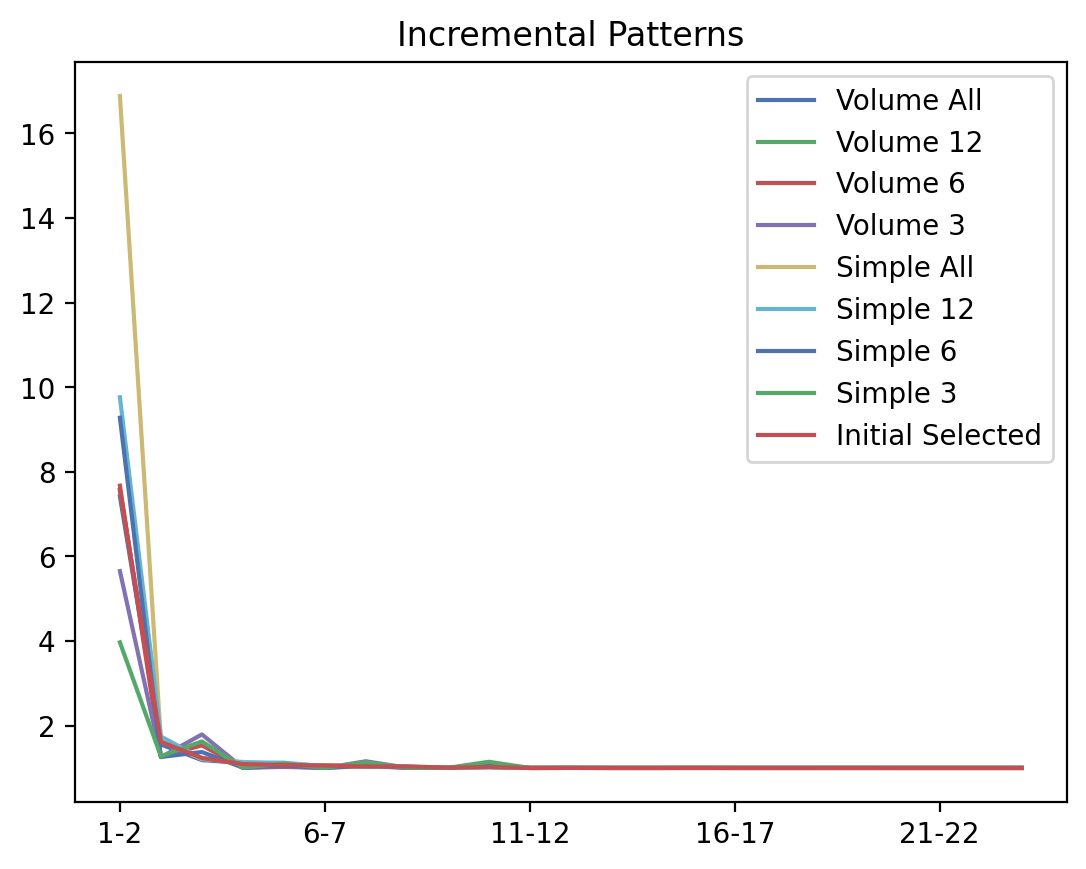

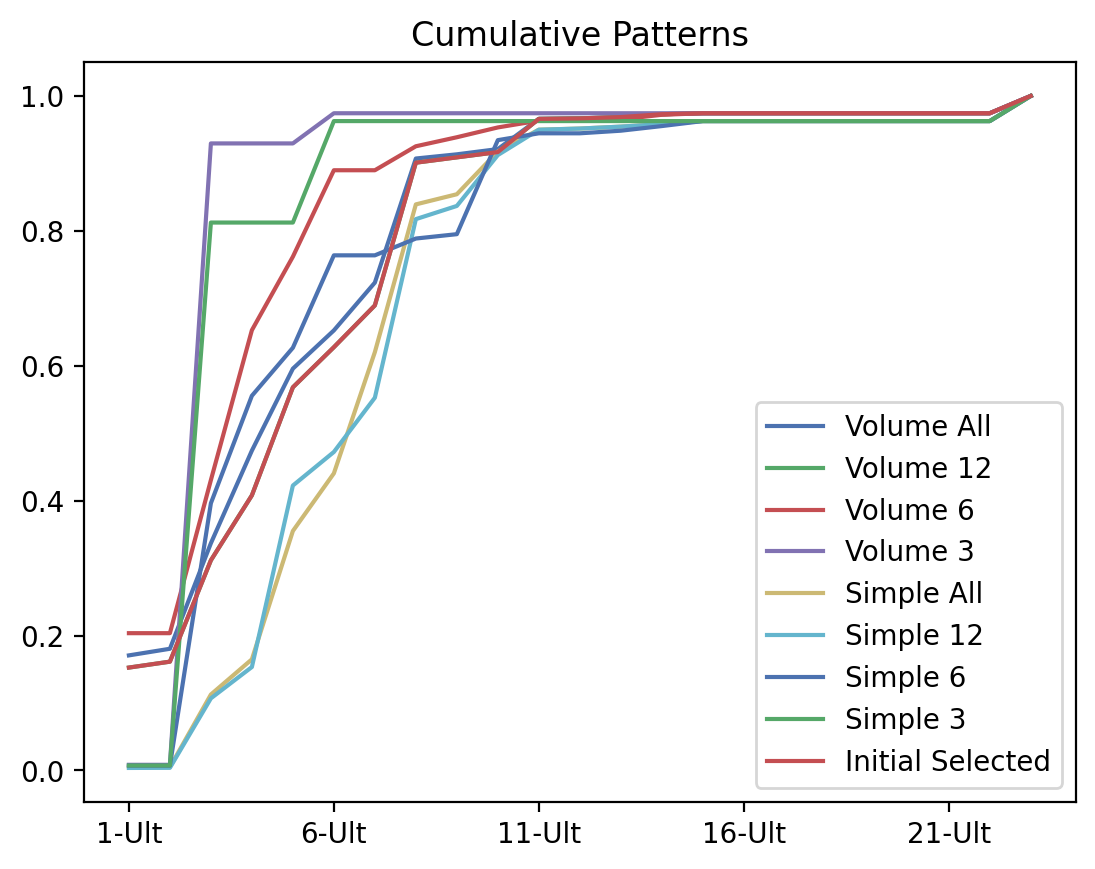

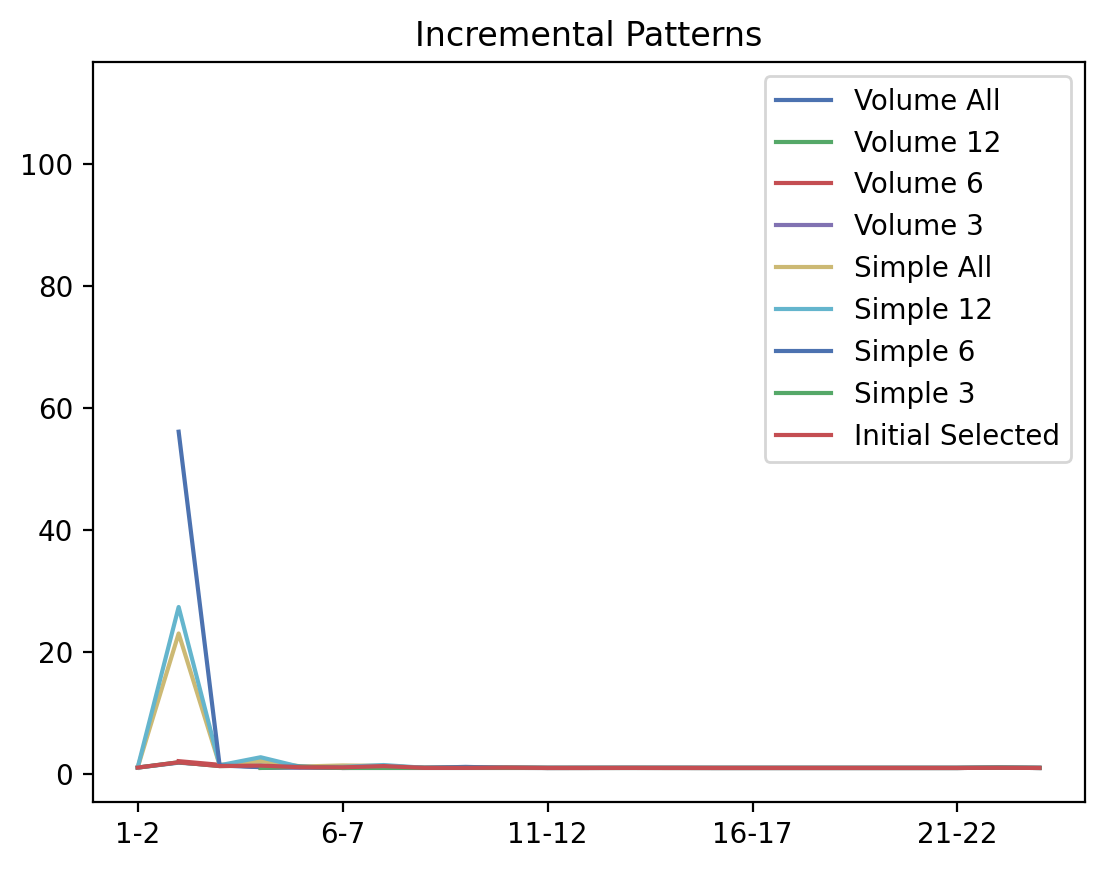

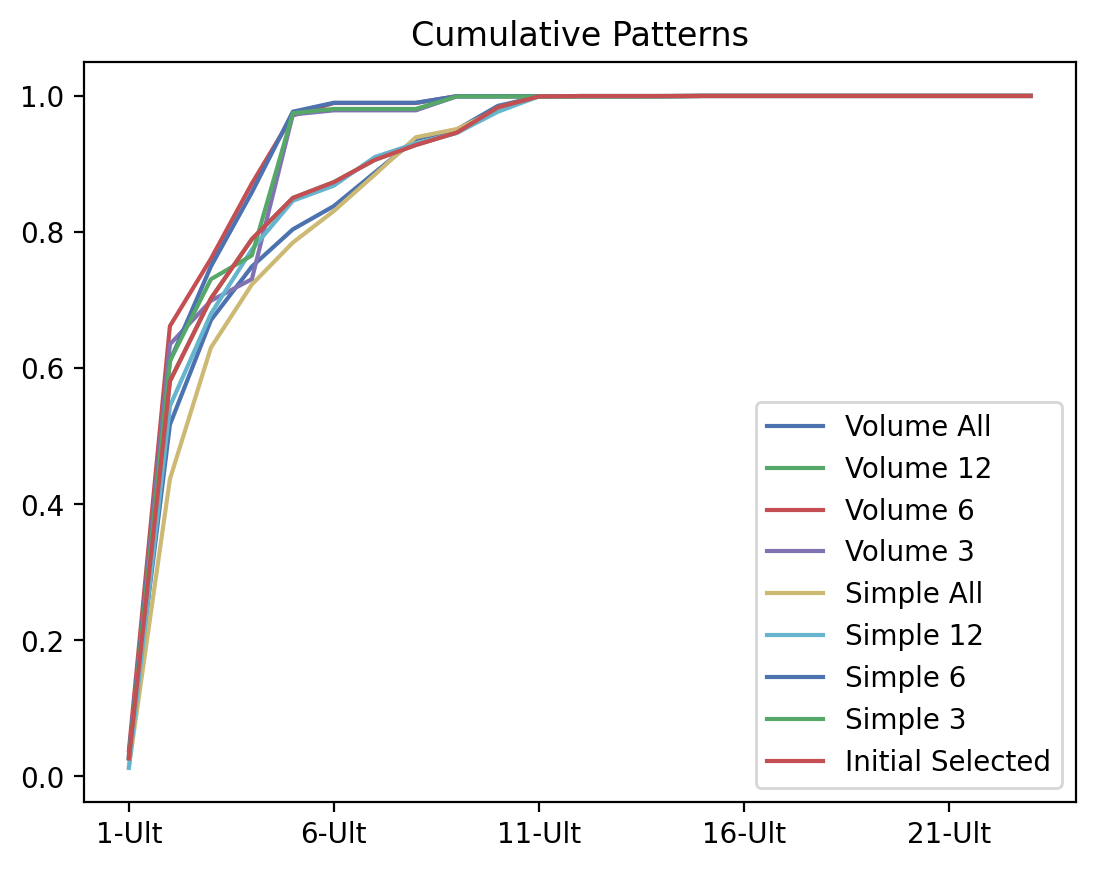

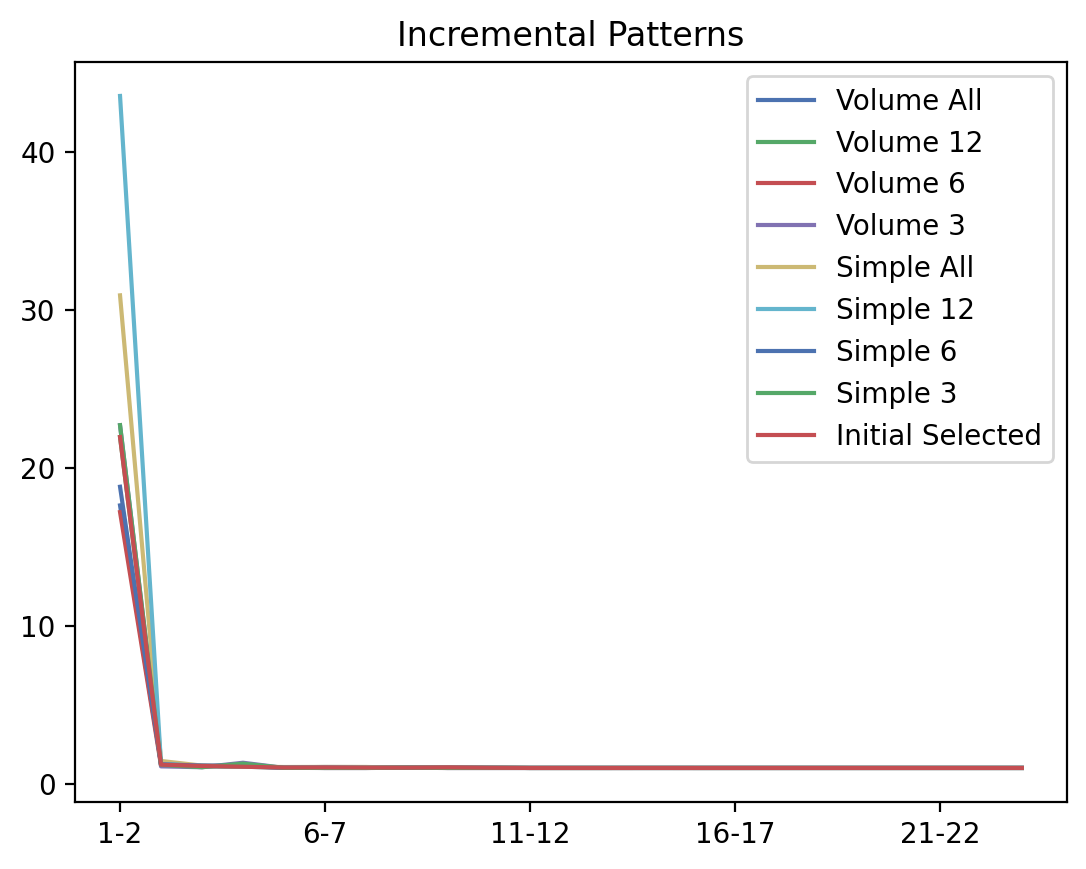

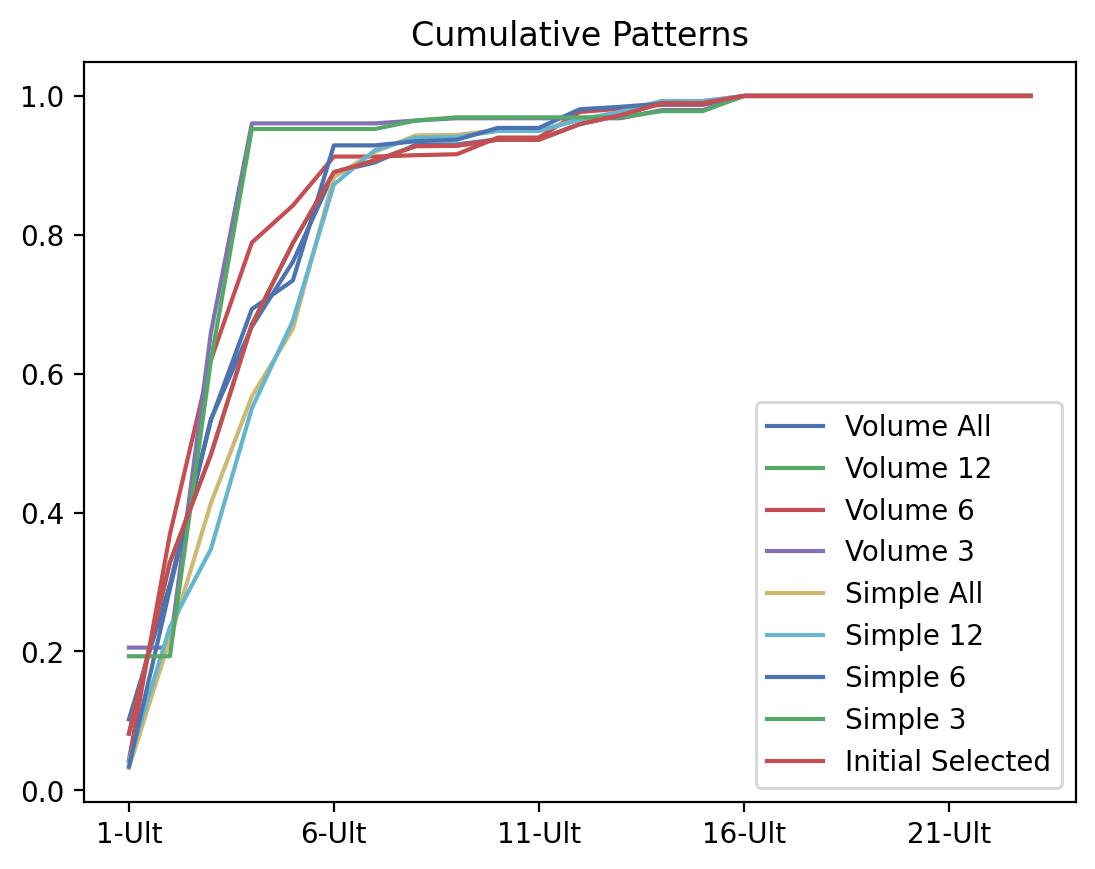

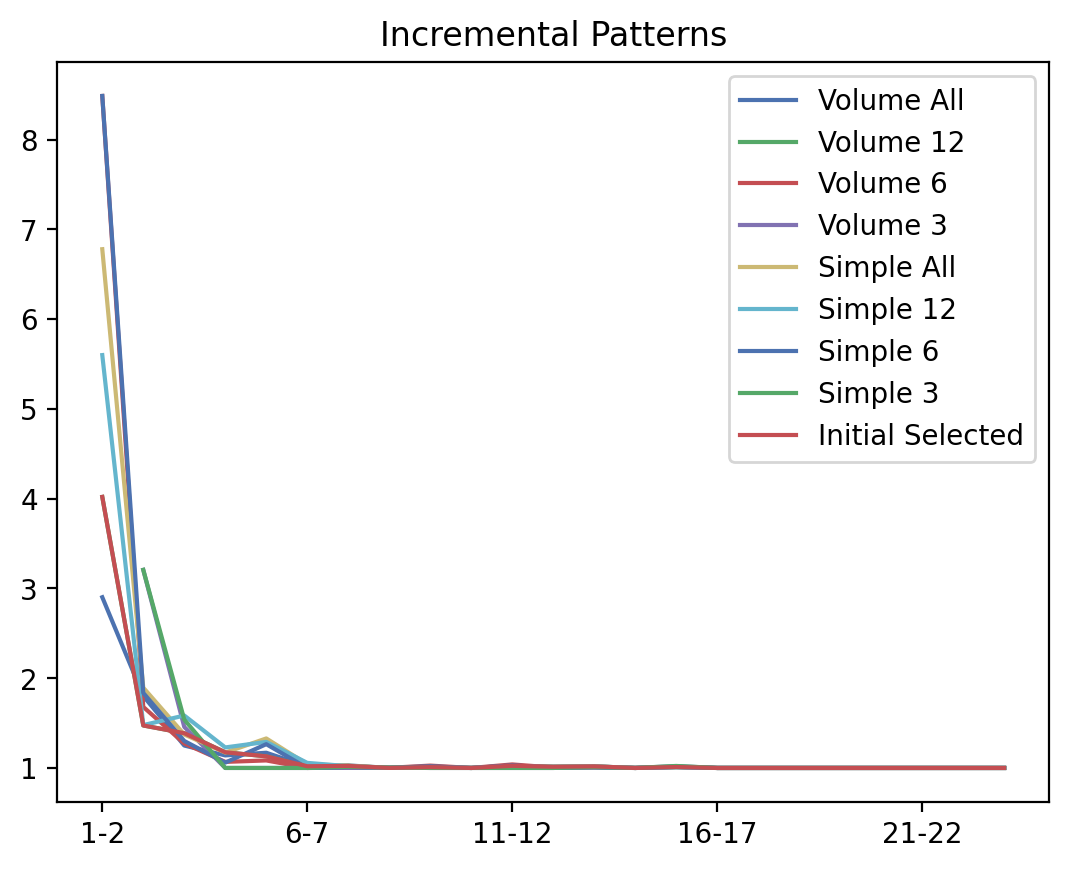

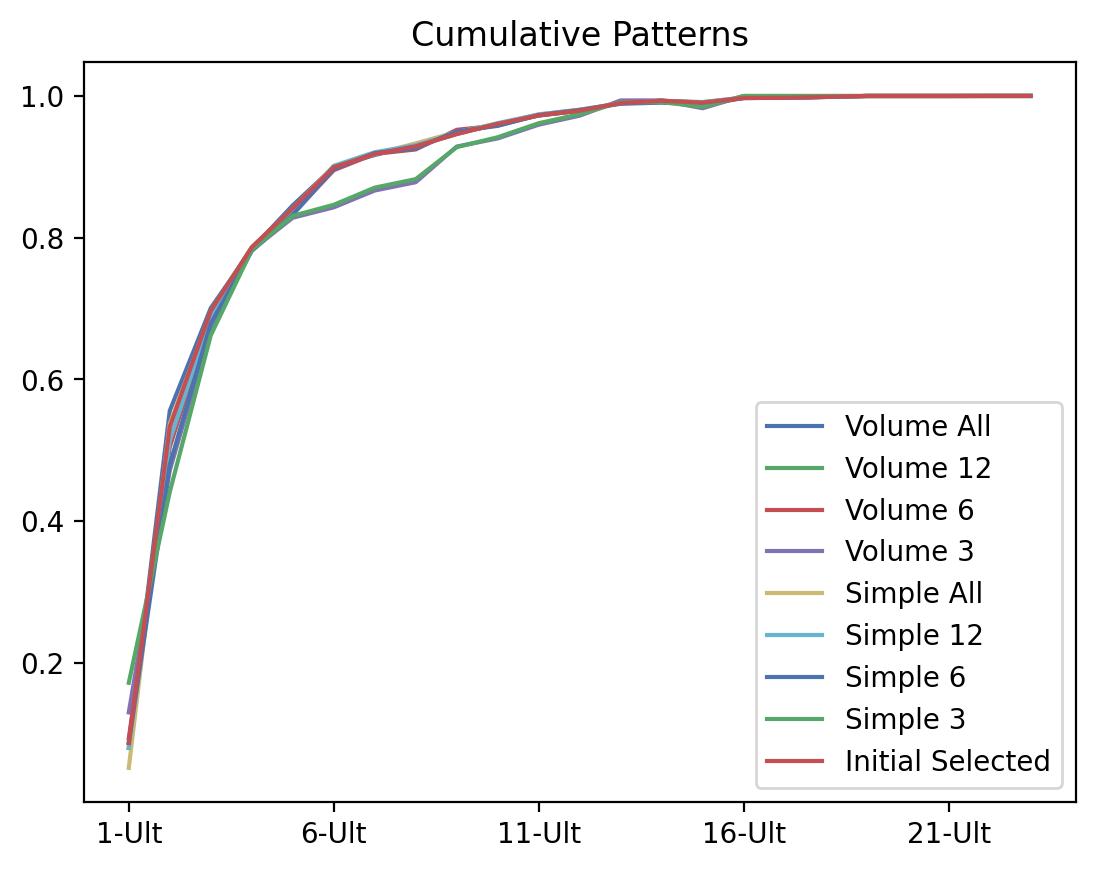

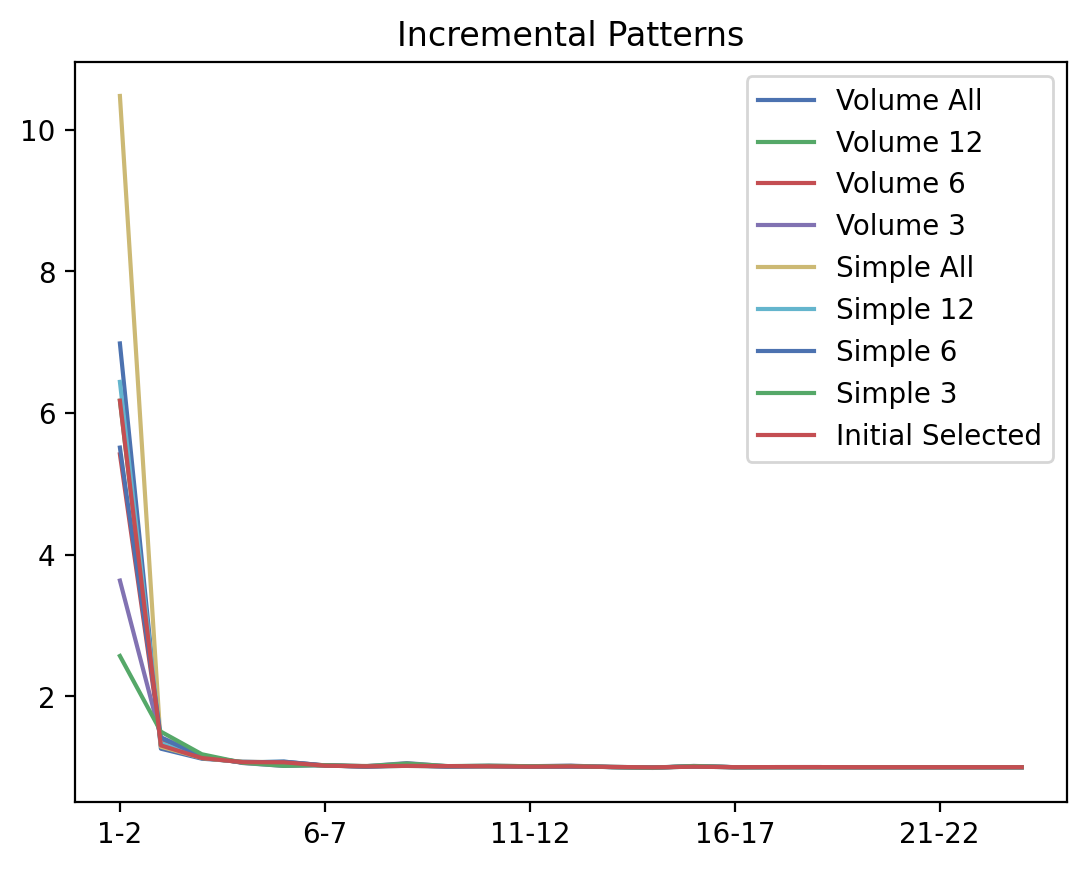

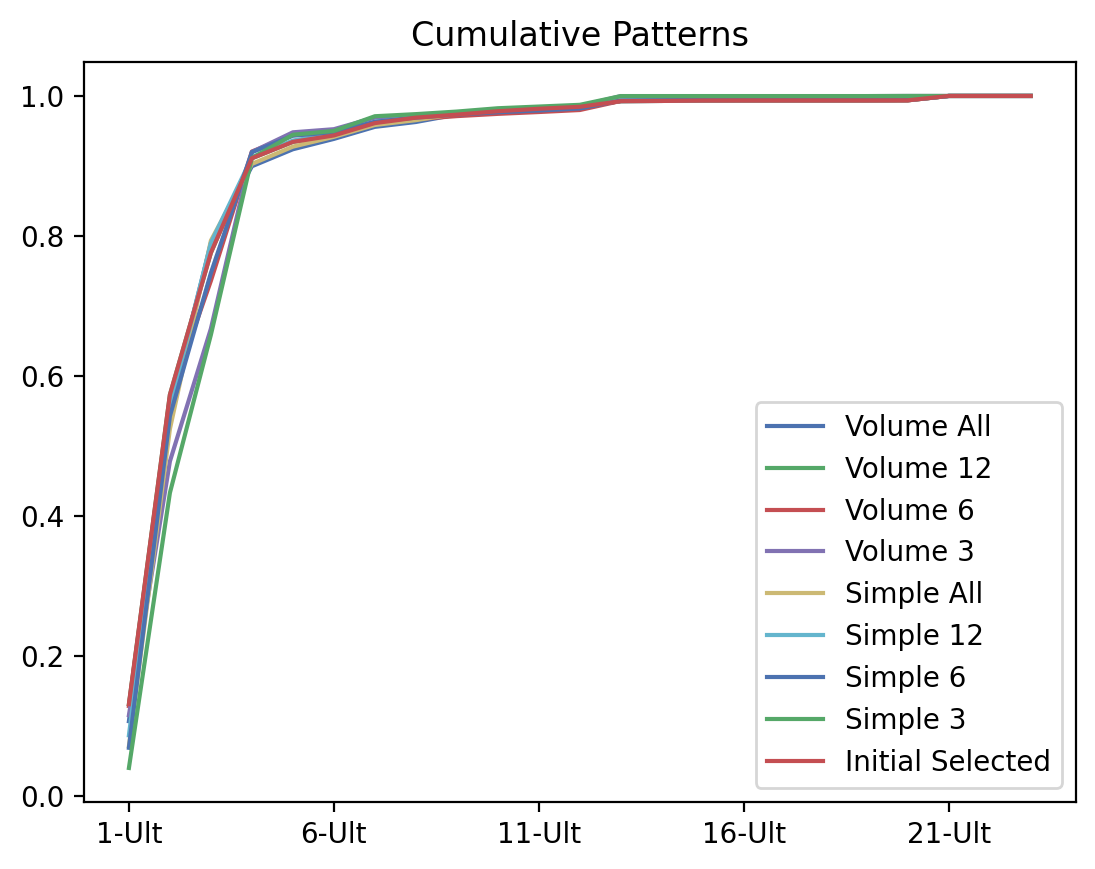

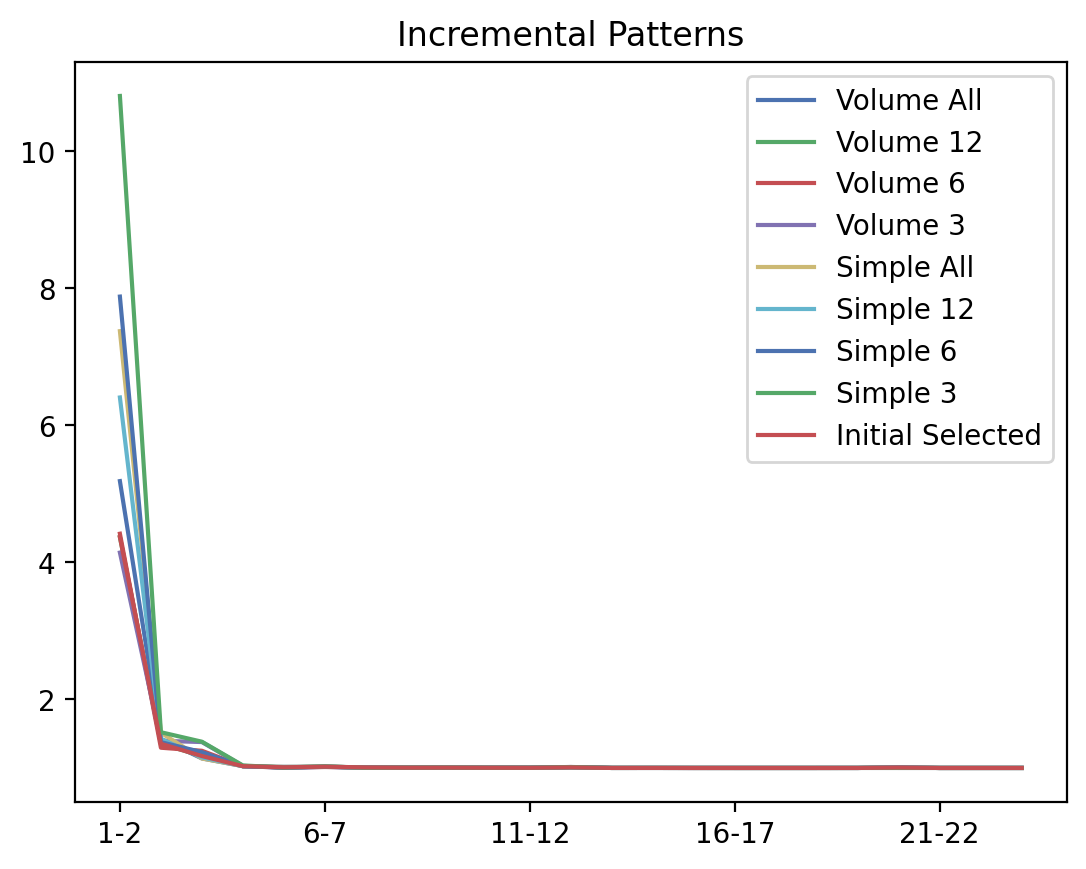

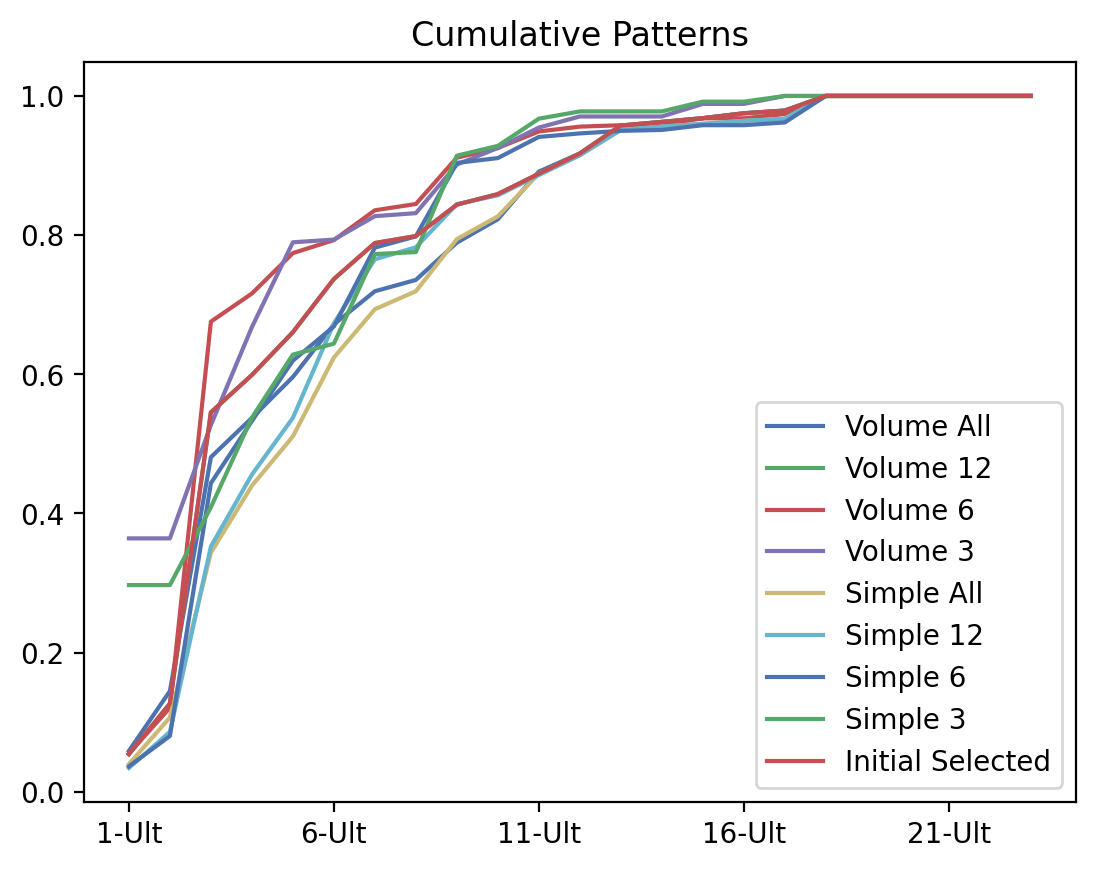

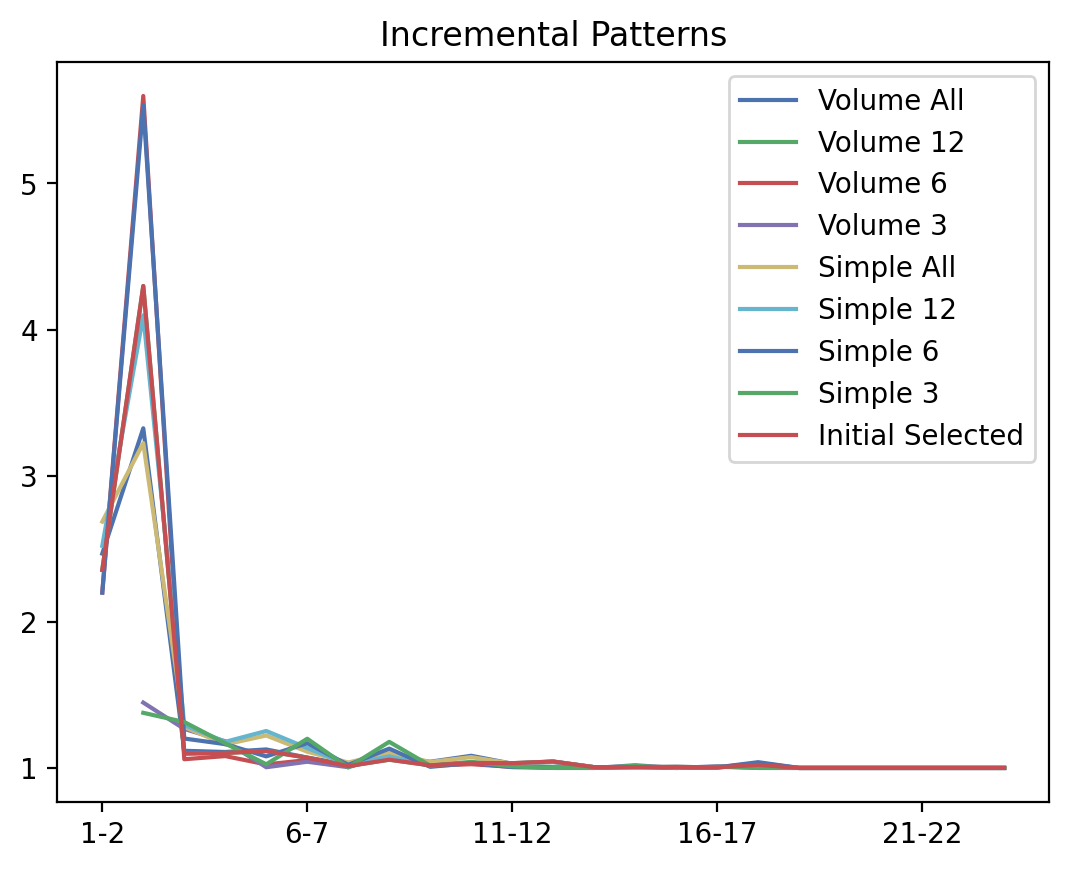

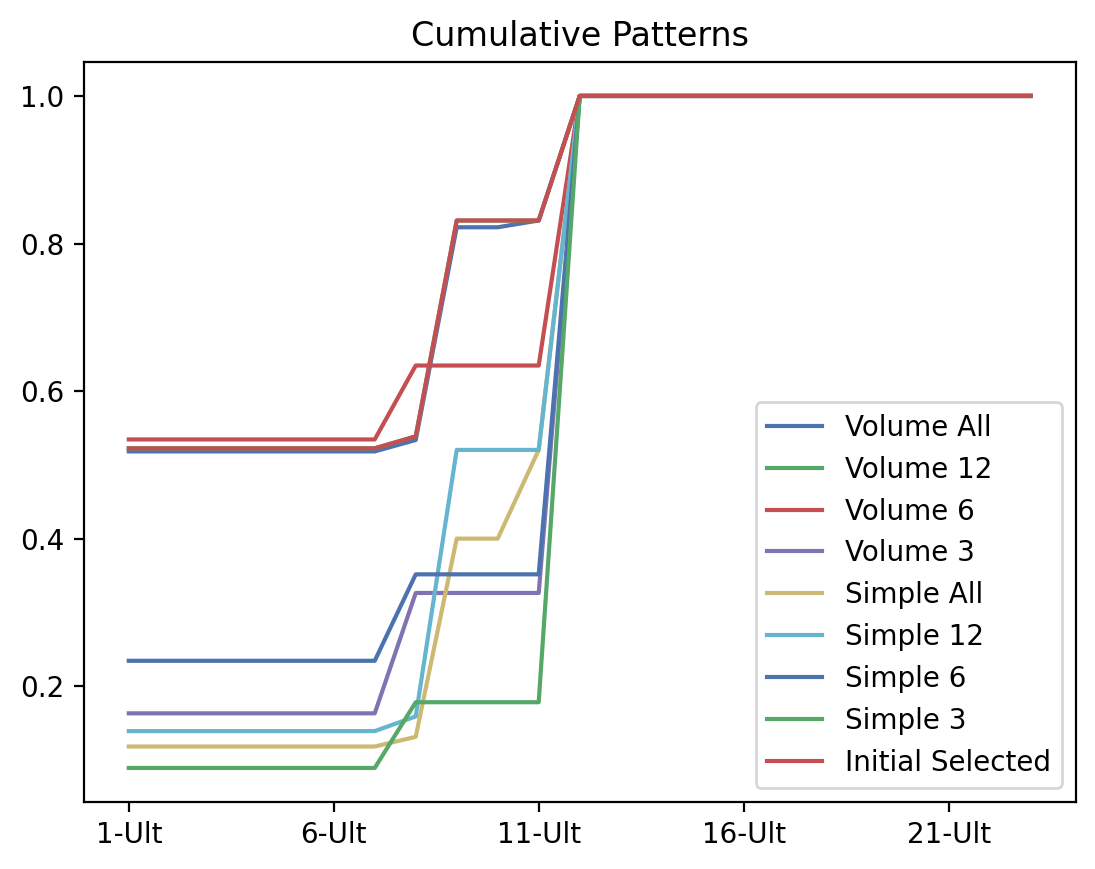

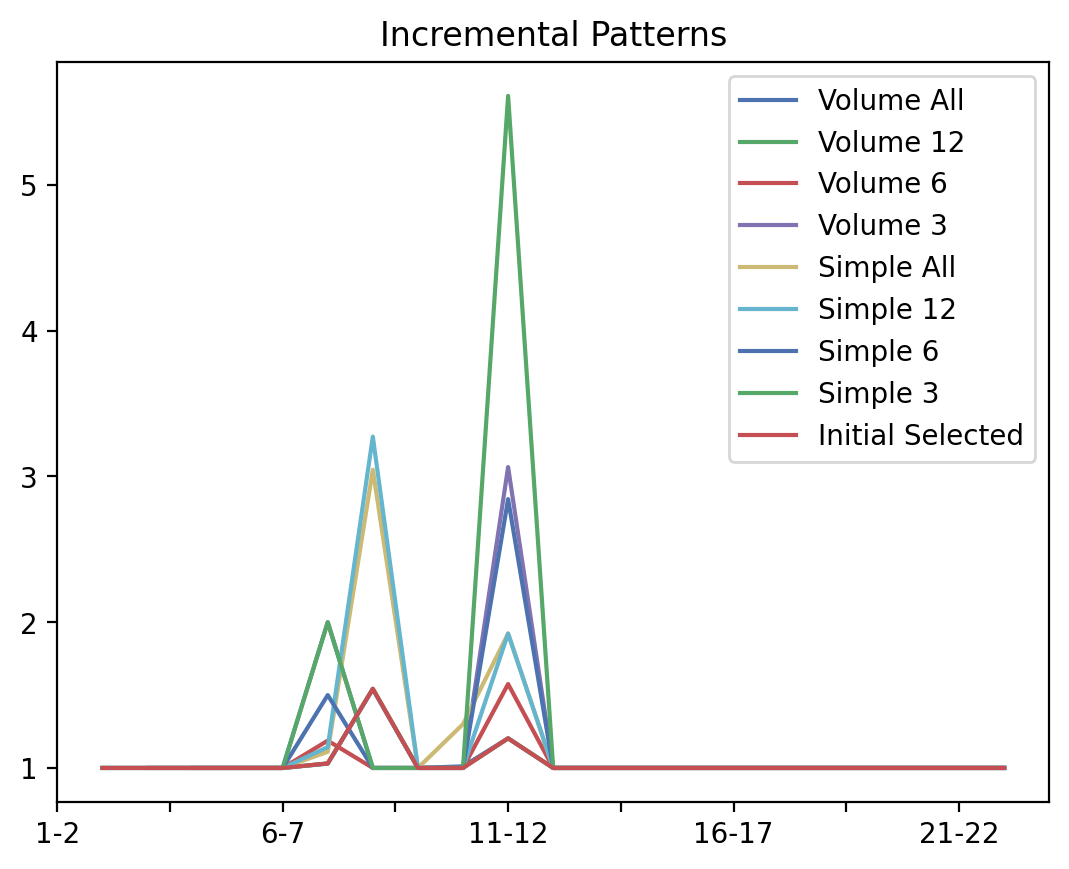

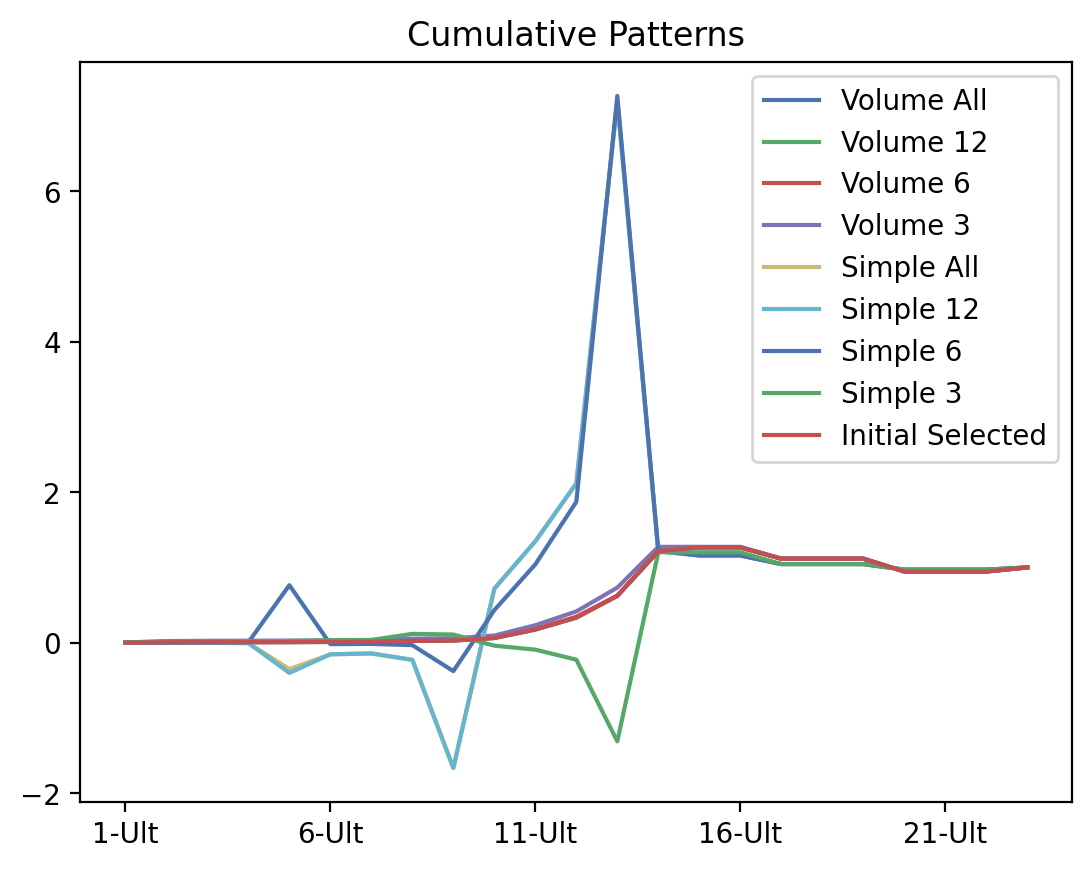

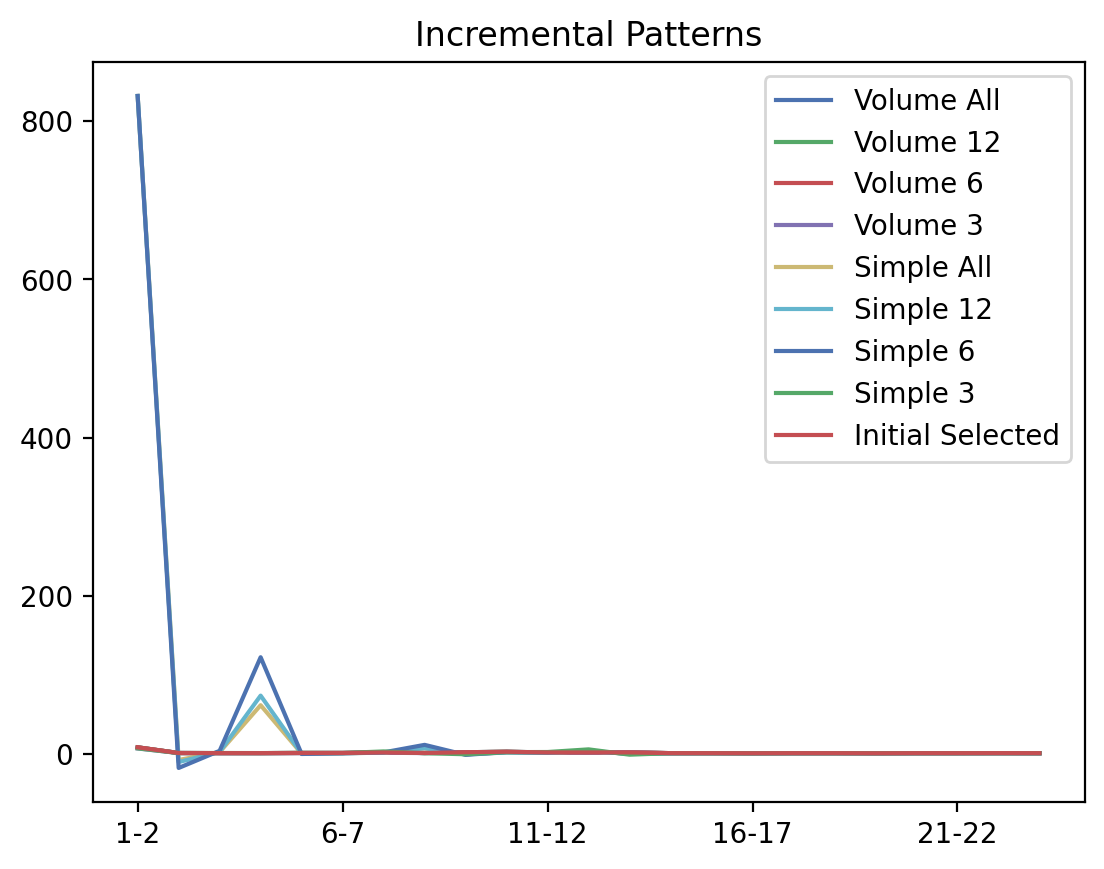

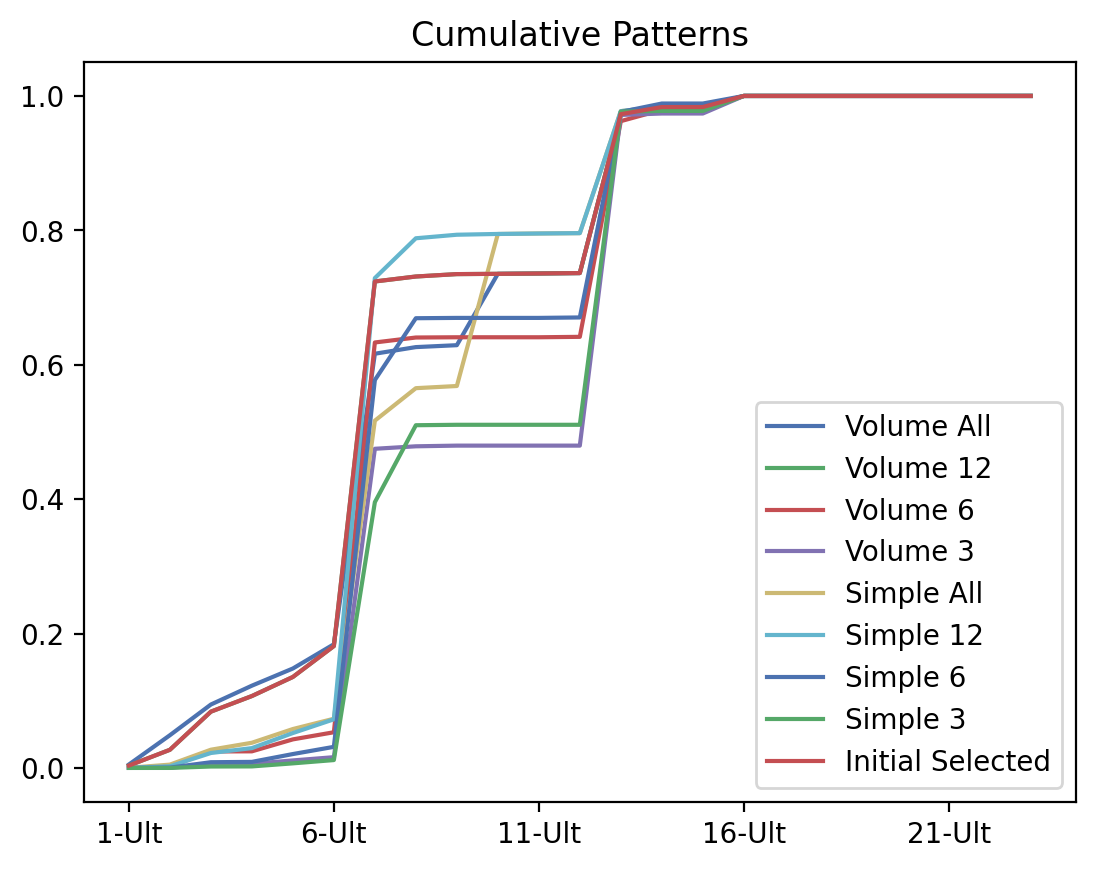

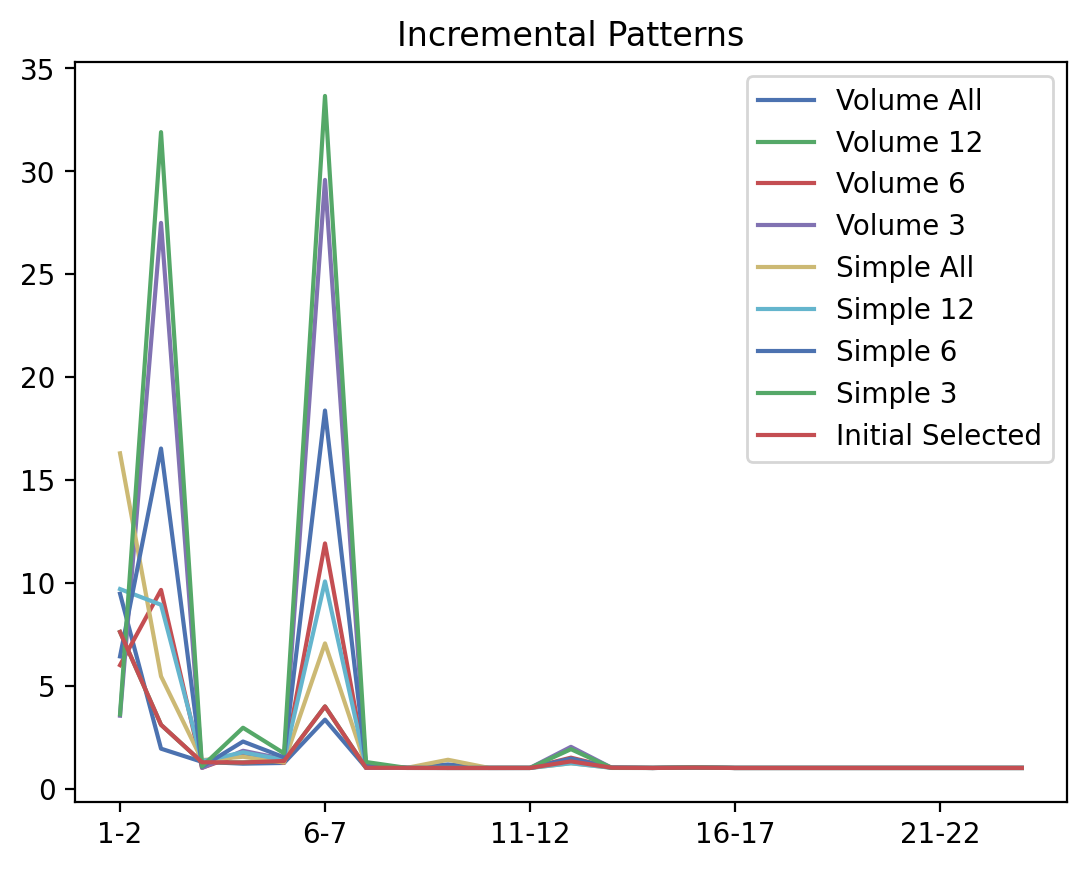

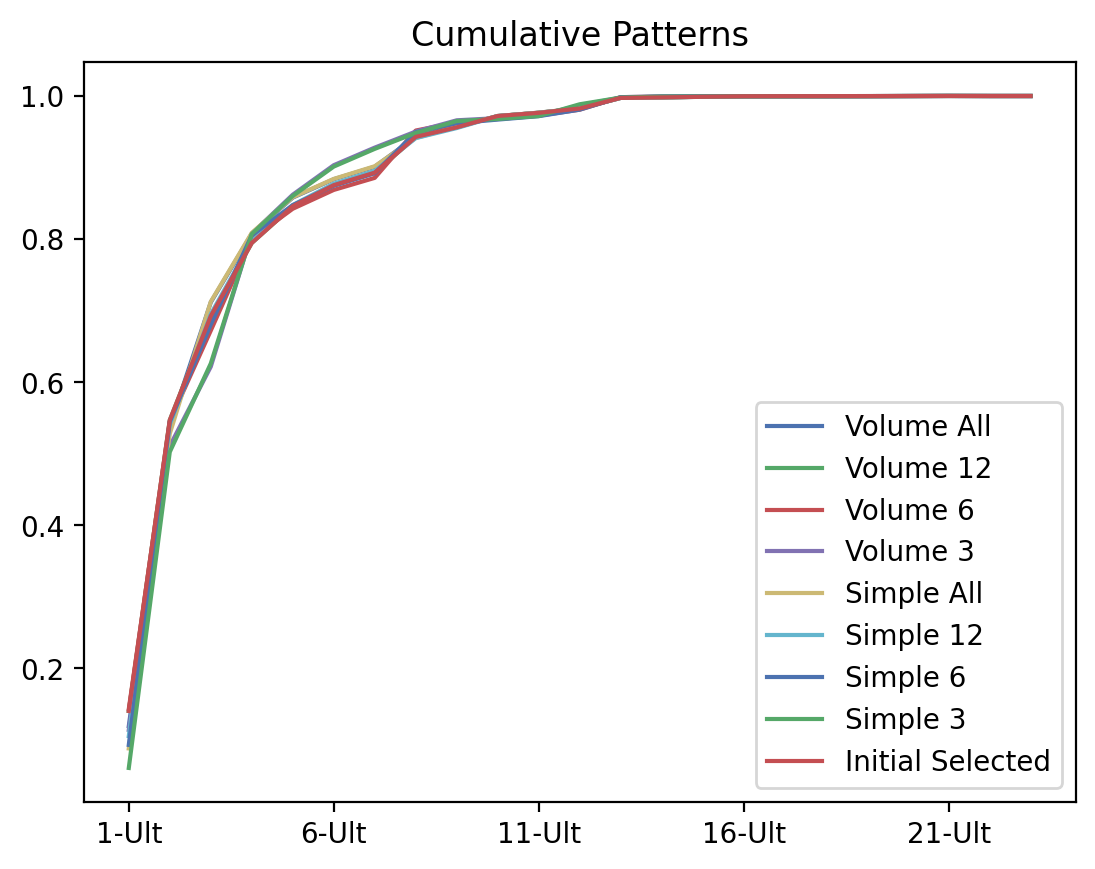

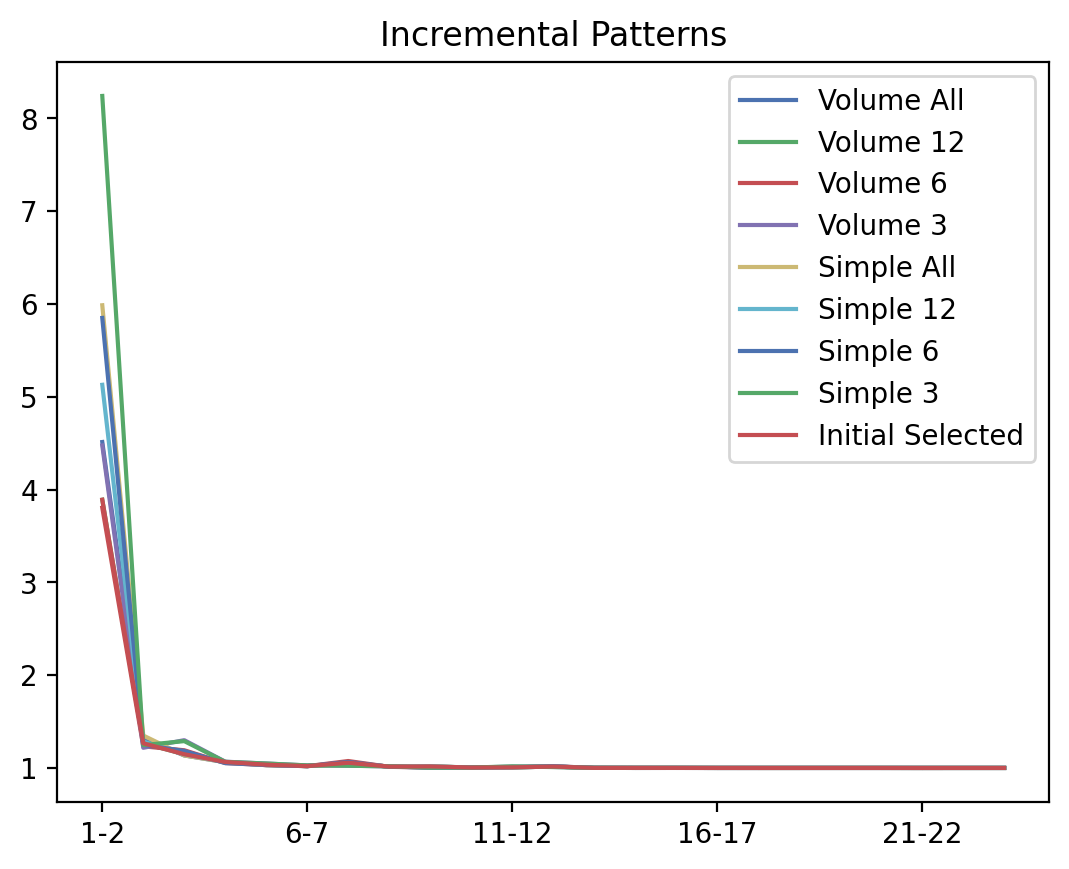

In [8]:
"""Culative Patterns Plot"""

plot_Patterns_Cum={}
plot_Patterns_Inc={}

for n in Company_ID_List:

    plot_Patterns_Cum[n]=pd.concat([(1/transformed_triangleVolumeAll[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume All'}),(1/transformed_triangleVolume12[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 12'}),(1/transformed_triangleVolume6[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 6'}),(1/transformed_triangleVolume3[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 3'}),(1/transformed_triangleSimpleAll[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple All'}), (1/transformed_triangleSimple12[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 12'}),(1/transformed_triangleSimple6[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 6'}),(1/transformed_triangleSimple3[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 3'}),(1/cdfInitialSelected[n]).to_frame(origin_as_datetime=False).rename({'(All)':'Initial Selected'})]).T.plot(marker="",title="Cumulative Patterns")
    plot_Patterns_Inc[n]=pd.concat([(transformed_triangleVolumeAll[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume All'}),(transformed_triangleVolume12[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 12'}),(transformed_triangleVolume6[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 6'}),(transformed_triangleVolume3[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 3'}),(transformed_triangleSimpleAll[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple All'}),(transformed_triangleSimple12[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 12'}),(transformed_triangleSimple6[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 6'}),(transformed_triangleSimple3[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 3'}),(ldfInitialSelected[n]).to_frame(origin_as_datetime=False).rename({'(All)':'Initial Selected'})]).T.plot(marker="",title="Incremental Patterns")


In [9]:
"""Update Excel Tempalte"""

paid_cum_df={}
plot_Patterns_Cum_df={}
plot_Patterns_Inc_df={}

for n in Company_ID_List:
       
    workbook = openpyxl.load_workbook('Unified_IBNP_Template_v2.xlsx')

    template_plot_patterns = workbook['Plot Patterns']
    
    plot_Patterns_Cum_df[n]=pd.concat([(1/transformed_triangleVolumeAll[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume All'}),(1/transformed_triangleVolume12[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 12'}),(1/transformed_triangleVolume6[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 6'}),(1/transformed_triangleVolume3[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 3'}),(1/transformed_triangleSimpleAll[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple All'}), (1/transformed_triangleSimple12[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 12'}),(1/transformed_triangleSimple6[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 6'}),(1/transformed_triangleSimple3[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 3'}),(1/cdfInitialSelected[n]).to_frame(origin_as_datetime=False).rename({'(All)':'Initial Selected'})]).T
    plot_Patterns_Inc_df[n]=pd.concat([(transformed_triangleVolumeAll[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume All'}),(transformed_triangleVolume12[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 12'}),(transformed_triangleVolume6[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 6'}),(transformed_triangleVolume3[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 3'}),(transformed_triangleSimpleAll[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple All'}),(transformed_triangleSimple12[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 12'}),(transformed_triangleSimple6[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 6'}),(transformed_triangleSimple3[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 3'}),(ldfInitialSelected[n]).to_frame(origin_as_datetime=False).rename({'(All)':'Initial Selected'})]).T

    template_plot_patterns = workbook['Plot Patterns']

    rows_plot_patterns_cum = list(dataframe_to_rows(plot_Patterns_Cum_df[n], index=False, header=False))
    for r_idx, row in enumerate(rows_plot_patterns_cum, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_plot_patterns.cell(row=r_idx + 1, column=c_idx + 1, value=value)

    rows_plot_patterns_inc = list(dataframe_to_rows(plot_Patterns_Inc_df[n], index=False, header=False))
    for r_idx, row in enumerate(rows_plot_patterns_inc, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_plot_patterns.cell(row=r_idx + 1, column=c_idx + 13, value=value)

    template_link_ratios = workbook['Completion Factors']

    rows_link_ratios = list(dataframe_to_rows(triangle_factors_df[n], index=False, header=False))
    for r_idx, row in enumerate(rows_link_ratios, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_link_ratios.cell(row=r_idx + 37, column=c_idx + 1, value=value)

                        
    rows_cdf_Simple3=list(dataframe_to_rows(cdfSimple3_df[n],index=False, header=False))
    for r_idx, row in enumerate(rows_cdf_Simple3,start=1):
            for c_idx, value in enumerate(row, start=1):
                template_link_ratios.cell(row=r_idx + 6, column=c_idx + 4, value=value)
            

    rows_cdf_Simple6=list(dataframe_to_rows(cdfSimple6_df[n],index=False, header=False))
    for r_idx, row in enumerate(rows_cdf_Simple6,start=1):
        for c_idx, value in enumerate(row, start=1):
                template_link_ratios.cell(row=r_idx + 6, column=c_idx + 5, value=value)


    rows_cdf_Simple12=list(dataframe_to_rows(cdfSimple12_df[n],index=False, header=False))
    for r_idx, row in enumerate(rows_cdf_Simple12,start=1):
        for c_idx, value in enumerate(row, start=1):
                template_link_ratios.cell(row=r_idx + 6, column=c_idx + 6, value=value)

    rows_cdf_Selected=list(dataframe_to_rows(cdfInitialSelected_df[n],index=False, header=False))
    for r_idx, row in enumerate(rows_cdf_Selected,start=1):
        for c_idx, value in enumerate(row, start=1):
                template_link_ratios.cell(row=r_idx + 6, column=c_idx + 8, value=value)


    template_calculation = workbook['Summary']
    
    template_calculation.cell(row= 4, column=8, value=ValuationDate)

    rows_triangle = list(dataframe_to_rows(triangle_cum_df[n], index=False, header=False))
    for r_idx, row in enumerate(rows_triangle, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_calculation.cell(row=r_idx + 7, column=c_idx + 18, value=value)

    paid_cum_df[n]=triangle_cum[n].latest_diagonal.to_frame()

    rows_paid = list(dataframe_to_rows(paid_cum_df[n], index=False, header=False))
    for r_idx, row in enumerate(rows_paid, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_calculation.cell(row=r_idx + 7, column=c_idx + 1, value=value)

    rows_premium = list(dataframe_to_rows(EarnedPremium_df[n], index=False, header=False))
    for r_idx, row in enumerate(rows_premium, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_calculation.cell(row=r_idx + 7, column=c_idx + 8, value=value)

    rows_loss_ratio_1 = list(dataframe_to_rows(LossRatio_1[n], index=False, header=False))
    for r_idx, row in enumerate(rows_loss_ratio_1, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_calculation.cell(row=r_idx + 28, column=c_idx + 9, value=value)

    rows_loss_ratio_1 = list(dataframe_to_rows(LossRatio_2[n], index=False, header=False))
    for r_idx, row in enumerate(rows_loss_ratio_1, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_calculation.cell(row=r_idx + 29, column=c_idx + 9, value=value)

    rows_loss_ratio_1 = list(dataframe_to_rows(LossRatio_3[n], index=False, header=False))
    for r_idx, row in enumerate(rows_loss_ratio_1, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_calculation.cell(row=r_idx + 30, column=c_idx + 9, value=value)

                
                
    workbook.save('Unified_IBNP_'+n+'.xlsx')

    print('Unified_IBNP_'+n+'.xlsx')




Unified_IBNP_ASL.xlsx
Unified_IBNP_AMH.xlsx
Unified_IBNP_GBR.xlsx
Unified_IBNP_GTL.xlsx
Unified_IBNP_NFL.xlsx
Unified_IBNP_NSL.xlsx
Unified_IBNP_PEN.xlsx
Unified_IBNP_PHS.xlsx
Unified_IBNP_PRT.xlsx
Unified_IBNP_SLI.xlsx
Unified_IBNP_ULI.xlsx
Unified_IBNP_USH.xlsx
Unified_IBNP_XCH.xlsx


In [10]:
"""set the cumulative 24 months triangle and process for each client split by MS and NMS"""

ValuationDate= datetime.date(2024,3,31)
ValuationDate_Text=f'{ValuationDate.year}-{ValuationDate.month}-{ValuationDate.day}'
InitialDate= f'{ValuationDate.year-2}-{ValuationDate.month}-{ValuationDate.day}'

MS_List=['Medicare Supplement - Pre-Standard (CR)','Medicare Supplement - Pre-Standard (GR)','Medicare Supplement - Pre-Standard (NR)','Medicare Supplement - Standard (GR)', 'Medicare Supplement - Standard - Select (GR)']

df=df[df.Paid_Date<=ValuationDate]
df_MS=df[df['Line_Of_Business'].isin(MS_List)]

Premium_triangle=wep[((wep.origin>InitialDate) & (wep.origin<=ValuationDate_Text))]

Company_ID_List_Split=['USH']

triangle_var={}
triangle_cum={}
triangle_cum_df={}
EarnedPremium={}
EarnedPremium_df={}
LossRatio={}
LossRatio_1={}
LossRatio_2={}
LossRatio_3={}
triangle_MS_var={}
triangle_MS_cum={}
triangle_MS_cum_df={}
triangle_MS_factors={}
triangle_MS_factors_df={}
transformed_triangle_MS_VolumeAll={}
ldfVolumeAll_MS={}
cdfVolumeAll_MS={}
cdfVolumeAll_MS_df={}
transformed_triangle_MS_Volume12={}
ldfVolume12_MS={}
cdfVolume12_MS={}
cdfVolume12_MS_df={}
transformed_triangle_MS_Volume6={}
ldfVolume6_MS={}
cdfVolume6_MS={}
cdfVolume6_MS_df={}
transformed_triangle_MS_Volume3={}
ldfVolume3_MS={}
cdfVolume3_MS={}
cdfVolume3_MS_df={}  
transformed_triangle_MS_SimpleAll={}
ldfSimpleAll_MS={}
cdfSimpleAll_MS={}
cdfSimpleAll_MS_df={}
transformed_triangle_MS_Simple12={}
ldfSimple12_MS={}
cdfSimple12_MS={}
cdfSimple12_MS_df={}
transformed_triangle_MS_Simple6={}
ldfSimple6_MS={}
cdfSimple6_MS={}
cdfSimple6_MS_df={}
transformed_triangle_MS_Simple3={}
ldfSimple3_MS={}
cdfSimple3_MS={}
cdfSimple3_MS_df={}

ldfInitialSelected_MS={}
cdfInitialSelected_MS={}
ldfInitialSelected_MS_df={}
cdfInitialSelected_MS_df={}

triangle_NMS_var={}
triangle_NMS_cum={}
triangle_NMS_cum_df={}
triangle_NMS_factors={}
triangle_NMS_factors_df={}
transformed_triangle_NMS_VolumeAll={}
ldfVolumeAll_NMS={}
cdfVolumeAll_NMS={}
cdfVolumeAll_NMS_df={}
transformed_triangle_NMS_Volume12={}
ldfVolume12_NMS={}
cdfVolume12_NMS={}
cdfVolume12_NMS_df={}
transformed_triangle_NMS_Volume6={}
ldfVolume6_NMS={}
cdfVolume6_NMS={}
cdfVolume6_NMS_df={}
transformed_triangle_NMS_Volume3={}
ldfVolume3_NMS={}
cdfVolume3_NMS={}
cdfVolume3_NMS_df={}  
transformed_triangle_NMS_SimpleAll={}
ldfSimpleAll_NMS={}
cdfSimpleAll_NMS={}
cdfSimpleAll_NMS_df={}
transformed_triangle_NMS_Simple12={}
ldfSimple12_NMS={}
cdfSimple12_NMS={}
cdfSimple12_NMS_df={}
transformed_triangle_NMS_Simple6={}
ldfSimple6_NMS={}
cdfSimple6_NMS={}
cdfSimple6_NMS_df={}
transformed_triangle_NMS_Simple3={}
ldfSimple3_NMS={}
cdfSimple3_NMS={}
cdfSimple3_NMS_df={}

ldfInitialSelected_NMS={}
cdfInitialSelected_NMS={}
ldfInitialSelected_NMS_df={}
cdfInitialSelected_NMS_df={}

triangle={}
OutlierLimit={}
df_lim={}
we_lim={}

triangle_MS={}
df_MS_lim={}
we_MS_lim={}

triangle_NMS={}


OutlierLimit['USH']=10000000


for n in Company_ID_List_Split:

   df_lim[n]=df[(df.Claim_Amount<OutlierLimit[n]) & (df.Claim_Amount>-OutlierLimit[n])]

   df_MS_lim[n]=df_MS[(df_MS.Claim_Amount<OutlierLimit[n]) & (df_MS.Claim_Amount>-OutlierLimit[n])]

   InputOrigin='Incurred_Date'
   InputDevelopment='Paid_Date'
   InputColumns='Claim_Amount'
   InputCumulative=False
   InputCompany="Company_ID"
   #InputBlock="Block_ID"
   #InputLOB="Line_Of_Business"


   we_lim[n] = cl.Triangle(
      df_lim[n],
      origin=InputOrigin,
      development=InputDevelopment,
      columns=InputColumns,
      index=[InputCompany],
      cumulative=InputCumulative
   )

   we_MS_lim[n]=cl.Triangle(
      df_MS_lim[n],
      origin=InputOrigin,
      development=InputDevelopment,
      columns=InputColumns,
      index=[InputCompany],
      cumulative=InputCumulative
   )


   triangle[n]=we_lim[n][((we_lim[n].origin>InitialDate) & (we_lim[n].origin<=ValuationDate_Text))][we_lim[n].development<25]
   triangle_var[n]=triangle[n].loc[n]  
   triangle_cum[n] = triangle_var[n].incr_to_cum()
   triangle_cum_df[n]=triangle_cum[n].to_frame()

   triangle_MS[n]=we_MS_lim[n][((we_MS_lim[n].origin>InitialDate) & (we_MS_lim[n].origin<=ValuationDate_Text))][we_MS_lim[n].development<25]
   triangle_MS_var[n]=triangle_MS[n].loc[n]  
   triangle_MS_cum[n] = triangle_MS_var[n].incr_to_cum()
   triangle_MS_cum_df[n]=triangle_MS_cum[n].to_frame()

   triangle_NMS[n]=triangle[n]-triangle_MS[n]
   triangle_NMS_var[n]=triangle_var[n]-triangle_MS_var[n] 
   triangle_NMS_cum[n] = triangle_cum[n]-triangle_MS_cum[n]
   triangle_NMS_cum_df[n]=triangle_NMS_cum[n].to_frame()
   
   triangle_MS_factors[n] = triangle_MS_cum[n].link_ratio
   triangle_MS_factors_df[n]=triangle_MS_factors[n].to_frame()

   triangle_NMS_factors[n] = triangle_NMS_cum[n].link_ratio
   triangle_NMS_factors_df[n]=triangle_NMS_factors[n].to_frame()
   
   EarnedPremium[n]= Premium_triangle.loc[n]/12
   EarnedPremium_df[n]=EarnedPremium[n].to_frame()

   LossRatio[n]=lr_input[lr_input.Client_ID==n]
   LossRatio_1[n]=LossRatio[n].Month_Minus_1.to_frame()
   LossRatio_2[n]=LossRatio[n].Month_Minus_2.to_frame()
   LossRatio_3[n]=LossRatio[n].Month_Minus_3.to_frame()

   #Different Averages n
   VolumeAll=cl.Development(average='volume',n_periods=24)
   transformed_triangle_MS_VolumeAll[n]= VolumeAll.fit_transform(triangle_MS_cum[n])
   ldfVolumeAll_MS[n]=transformed_triangle_MS_VolumeAll[n].ldf_
   cdfVolumeAll_MS[n]=transformed_triangle_MS_VolumeAll[n].cdf_
   cdfVolumeAll_MS_df[n]=(1/cdfVolumeAll_MS[n]).T
   transformed_triangle_NMS_VolumeAll[n]= VolumeAll.fit_transform(triangle_NMS_cum[n])
   ldfVolumeAll_NMS[n]=transformed_triangle_NMS_VolumeAll[n].ldf_
   cdfVolumeAll_NMS[n]=transformed_triangle_NMS_VolumeAll[n].cdf_
   cdfVolumeAll_NMS_df[n]=(1/cdfVolumeAll_NMS[n]).T

   Volume12=cl.Development(average='volume',n_periods=12)
   transformed_triangle_MS_Volume12[n]= Volume12.fit_transform(triangle_MS_cum[n])
   ldfVolume12_MS[n]=transformed_triangle_MS_Volume12[n].ldf_
   cdfVolume12_MS[n]=transformed_triangle_MS_Volume12[n].cdf_
   cdfVolume12_MS_df[n]=(1/cdfVolume12_MS[n]).T
   transformed_triangle_NMS_Volume12[n]= Volume12.fit_transform(triangle_NMS_cum[n])
   ldfVolume12_NMS[n]=transformed_triangle_NMS_Volume12[n].ldf_
   cdfVolume12_NMS[n]=transformed_triangle_NMS_Volume12[n].cdf_
   cdfVolume12_NMS_df[n]=(1/cdfVolume12_NMS[n]).T

   Volume6=cl.Development(average='volume',n_periods=6)
   transformed_triangle_MS_Volume6[n]= Volume6.fit_transform(triangle_MS_cum[n])
   ldfVolume6_MS[n]=transformed_triangle_MS_Volume6[n].ldf_
   cdfVolume6_MS[n]=transformed_triangle_MS_Volume6[n].cdf_
   cdfVolume6_MS_df[n]=(1/cdfVolume6_MS[n]).T
   transformed_triangle_NMS_Volume6[n]= Volume6.fit_transform(triangle_NMS_cum[n])
   ldfVolume6_NMS[n]=transformed_triangle_NMS_Volume6[n].ldf_
   cdfVolume6_NMS[n]=transformed_triangle_NMS_Volume6[n].cdf_
   cdfVolume6_NMS_df[n]=(1/cdfVolume6_NMS[n]).T

   Volume3=cl.Development(average='volume',n_periods=3)
   transformed_triangle_MS_Volume3[n]= Volume3.fit_transform(triangle_MS_cum[n])
   ldfVolume3_MS[n]=transformed_triangle_MS_Volume3[n].ldf_
   cdfVolume3_MS[n]=transformed_triangle_MS_Volume3[n].cdf_
   cdfVolume3_MS_df[n]=(1/cdfVolume3_MS[n]).T
   transformed_triangle_NMS_Volume3[n]= Volume3.fit_transform(triangle_NMS_cum[n])
   ldfVolume3_NMS[n]=transformed_triangle_NMS_Volume3[n].ldf_
   cdfVolume3_NMS[n]=transformed_triangle_NMS_Volume3[n].cdf_
   cdfVolume3_NMS_df[n]=(1/cdfVolume3_NMS[n]).T
   
   SimpleAll=cl.Development(average='simple',n_periods=24)
   transformed_triangle_MS_SimpleAll[n]= SimpleAll.fit_transform(triangle_MS_cum[n])
   ldfSimpleAll_MS[n]=transformed_triangle_MS_SimpleAll[n].ldf_
   cdfSimpleAll_MS[n]=transformed_triangle_MS_SimpleAll[n].cdf_
   cdfSimpleAll_MS_df[n]=(1/cdfSimpleAll_MS[n]).T
   transformed_triangle_NMS_SimpleAll[n]= SimpleAll.fit_transform(triangle_NMS_cum[n])
   ldfSimpleAll_NMS[n]=transformed_triangle_NMS_SimpleAll[n].ldf_
   cdfSimpleAll_NMS[n]=transformed_triangle_NMS_SimpleAll[n].cdf_
   cdfSimpleAll_NMS_df[n]=(1/cdfSimpleAll_NMS[n]).T

   Simple12=cl.Development(average='simple',n_periods=12)
   transformed_triangle_MS_Simple12[n]= Simple12.fit_transform(triangle_MS_cum[n])
   ldfSimple12_MS[n]=transformed_triangle_MS_Simple12[n].ldf_
   cdfSimple12_MS[n]=transformed_triangle_MS_Simple12[n].cdf_
   cdfSimple12_MS_df[n]=(1/cdfSimple12_MS[n]).T
   transformed_triangle_NMS_Simple12[n]= Simple12.fit_transform(triangle_NMS_cum[n])
   ldfSimple12_NMS[n]=transformed_triangle_NMS_Simple12[n].ldf_
   cdfSimple12_NMS[n]=transformed_triangle_NMS_Simple12[n].cdf_
   cdfSimple12_NMS_df[n]=(1/cdfSimple12_NMS[n]).T

   Simple6=cl.Development(average='simple',n_periods=6)
   transformed_triangle_MS_Simple6[n]= Simple6.fit_transform(triangle_MS_cum[n])
   ldfSimple6_MS[n]=transformed_triangle_MS_Simple6[n].ldf_
   cdfSimple6_MS[n]=transformed_triangle_MS_Simple6[n].cdf_
   cdfSimple6_MS_df[n]=(1/cdfSimple6_MS[n]).T
   transformed_triangle_NMS_Simple6[n]= Simple6.fit_transform(triangle_NMS_cum[n])
   ldfSimple6_NMS[n]=transformed_triangle_NMS_Simple6[n].ldf_
   cdfSimple6_NMS[n]=transformed_triangle_NMS_Simple6[n].cdf_
   cdfSimple6_NMS_df[n]=(1/cdfSimple6_NMS[n]).T

   Simple3=cl.Development(average='simple',n_periods=3)
   transformed_triangle_MS_Simple3[n]= Simple3.fit_transform(triangle_MS_cum[n])
   ldfSimple3_MS[n]=transformed_triangle_MS_Simple3[n].ldf_
   cdfSimple3_MS[n]=transformed_triangle_MS_Simple3[n].cdf_
   cdfSimple3_MS_df[n]=(1/cdfSimple3_MS[n]).T
   transformed_triangle_NMS_Simple3[n]= Simple3.fit_transform(triangle_NMS_cum[n])
   ldfSimple3_NMS[n]=transformed_triangle_NMS_Simple3[n].ldf_
   cdfSimple3_NMS[n]=transformed_triangle_NMS_Simple3[n].cdf_
   cdfSimple3_NMS_df[n]=(1/cdfSimple3_MS[n]).T
   

   ldfInitialSelected_MS[n]=ldfVolume12_MS[n]
   cdfInitialSelected_MS[n]=(cdfVolume12_MS[n])  
   ldfInitialSelected_MS_df[n]=ldfInitialSelected_MS[n].to_frame()
   cdfInitialSelected_MS_df[n]=1/cdfInitialSelected_MS[n].T

   ldfInitialSelected_NMS[n]=ldfVolume12_NMS[n]
   cdfInitialSelected_NMS[n]=(cdfVolume12_MS[n])
   ldfInitialSelected_NMS_df[n]=ldfInitialSelected_NMS[n].to_frame()
   cdfInitialSelected_NMS_df[n]=1/cdfInitialSelected_NMS[n].T
   





c:\Users\joranias\AppData\Local\anaconda3\envs\Py311\Lib\site-packages\chainladder\core\base.py:106: UserWarning: 
                Observations with development before
                origin start have been removed.
  warnings.warn(
c:\Users\joranias\AppData\Local\anaconda3\envs\Py311\Lib\site-packages\chainladder\core\base.py:106: UserWarning: 
                Observations with development before
                origin start have been removed.
  warnings.warn(


In [11]:
"""Update Excel Tempalte Split"""

paid_cum_MS_df={}
paid_cum_NMS_df={}
plot_Patterns_Cum_MS_df={}
plot_Patterns_Inc_MS_df={}
plot_Patterns_Cum_NMS_df={}
plot_Patterns_Inc_NMS_df={}

for n in Company_ID_List_Split:
       
    workbook = openpyxl.load_workbook('Unified_IBNP_Template_Split_2.xlsx')

    template_plot_patterns = workbook['Plot Patterns']
    
    plot_Patterns_Cum_MS_df[n]=pd.concat([(1/transformed_triangle_MS_VolumeAll[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume All'}),(1/transformed_triangle_MS_Volume12[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 12'}),(1/transformed_triangle_MS_Volume6[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 6'}),(1/transformed_triangle_MS_Volume3[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 3'}),(1/transformed_triangle_MS_SimpleAll[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple All'}), (1/transformed_triangle_MS_Simple12[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 12'}),(1/transformed_triangle_MS_Simple6[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 6'}),(1/transformed_triangle_MS_Simple3[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 3'}),(1/cdfInitialSelected_MS[n]).to_frame(origin_as_datetime=False).rename({'(All)':'Initial Selected'})]).T
    plot_Patterns_Inc_MS_df[n]=pd.concat([(transformed_triangle_MS_VolumeAll[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume All'}),(transformed_triangle_MS_Volume12[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 12'}),(transformed_triangle_MS_Volume6[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 6'}),(transformed_triangle_MS_Volume3[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 3'}),(transformed_triangle_MS_SimpleAll[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple All'}),(transformed_triangle_MS_Simple12[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 12'}),(transformed_triangle_MS_Simple6[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 6'}),(transformed_triangle_MS_Simple3[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 3'}),(ldfInitialSelected_MS[n]).to_frame(origin_as_datetime=False).rename({'(All)':'Initial Selected'})]).T

    plot_Patterns_Cum_NMS_df[n]=pd.concat([(1/transformed_triangle_NMS_VolumeAll[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume All'}),(1/transformed_triangle_NMS_Volume12[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 12'}),(1/transformed_triangle_NMS_Volume6[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 6'}),(1/transformed_triangle_NMS_Volume3[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 3'}),(1/transformed_triangle_NMS_SimpleAll[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple All'}), (1/transformed_triangle_NMS_Simple12[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 12'}),(1/transformed_triangle_NMS_Simple6[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 6'}),(1/transformed_triangle_NMS_Simple3[n].cdf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 3'}),(1/cdfInitialSelected_NMS[n]).to_frame(origin_as_datetime=False).rename({'(All)':'Initial Selected'})]).T
    plot_Patterns_Inc_NMS_df[n]=pd.concat([(transformed_triangle_NMS_VolumeAll[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume All'}),(transformed_triangle_NMS_Volume12[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 12'}),(transformed_triangle_NMS_Volume6[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 6'}),(transformed_triangle_NMS_Volume3[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Volume 3'}),(transformed_triangle_NMS_SimpleAll[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple All'}),(transformed_triangle_NMS_Simple12[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 12'}),(transformed_triangle_NMS_Simple6[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 6'}),(transformed_triangle_NMS_Simple3[n].ldf_).to_frame(origin_as_datetime=False).rename({'(All)':'Simple 3'}),(ldfInitialSelected_NMS[n]).to_frame(origin_as_datetime=False).rename({'(All)':'Initial Selected'})]).T


    template_plot_patterns = workbook['Plot Patterns']

    rows_plot_patterns_cum_MS = list(dataframe_to_rows(plot_Patterns_Cum_MS_df[n], index=False, header=False))
    for r_idx, row in enumerate(rows_plot_patterns_cum_MS, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_plot_patterns.cell(row=r_idx + 1, column=c_idx + 1, value=value)

    rows_plot_patterns_inc_MS = list(dataframe_to_rows(plot_Patterns_Inc_MS_df[n], index=False, header=False))
    for r_idx, row in enumerate(rows_plot_patterns_inc_MS, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_plot_patterns.cell(row=r_idx + 1, column=c_idx + 13, value=value)

    rows_plot_patterns_cum_NMS = list(dataframe_to_rows(plot_Patterns_Cum_NMS_df[n], index=False, header=False))
    for r_idx, row in enumerate(rows_plot_patterns_cum_NMS, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_plot_patterns.cell(row=r_idx + 55, column=c_idx + 1, value=value)

    rows_plot_patterns_inc_NMS = list(dataframe_to_rows(plot_Patterns_Inc_NMS_df[n], index=False, header=False))
    for r_idx, row in enumerate(rows_plot_patterns_inc_NMS, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_plot_patterns.cell(row=r_idx + 55, column=c_idx + 13, value=value)

    template_link_ratios = workbook['Completion Factors']

    rows_link_ratios_NMS = list(dataframe_to_rows(triangle_NMS_factors_df[n], index=False, header=False))
    for r_idx, row in enumerate(rows_link_ratios_NMS, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_link_ratios.cell(row=r_idx + 37, column=c_idx + 1, value=value)

    rows_link_ratios_MS = list(dataframe_to_rows(triangle_MS_factors_df[n], index=False, header=False))
    for r_idx, row in enumerate(rows_link_ratios_MS, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_link_ratios.cell(row=r_idx + 98, column=c_idx + 1, value=value)

    rows_triangle_NMS = list(dataframe_to_rows(triangle_NMS_cum_df[n], index=False, header=False))
    for r_idx, row in enumerate(rows_triangle_NMS, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_link_ratios.cell(row=r_idx + 67, column=c_idx + 1, value=value)
                
    rows_triangle_MS = list(dataframe_to_rows(triangle_MS_cum_df[n], index=False, header=False))
    for r_idx, row in enumerate(rows_triangle_NMS, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_link_ratios.cell(row=r_idx + 126, column=c_idx + 1, value=value)

                        
    rows_cdf_Simple3_NMS=list(dataframe_to_rows(cdfSimple3_NMS_df[n],index=False, header=False))
    for r_idx, row in enumerate(rows_cdf_Simple3_NMS,start=1):
            for c_idx, value in enumerate(row, start=1):
                template_link_ratios.cell(row=r_idx + 6, column=c_idx + 4, value=value)
            

    rows_cdf_Simple6_NMS=list(dataframe_to_rows(cdfSimple6_NMS_df[n],index=False, header=False))
    for r_idx, row in enumerate(rows_cdf_Simple6_NMS,start=1):
        for c_idx, value in enumerate(row, start=1):
                template_link_ratios.cell(row=r_idx + 6, column=c_idx + 5, value=value)


    rows_cdf_Simple12_NMS=list(dataframe_to_rows(cdfSimple12_NMS_df[n],index=False, header=False))
    for r_idx, row in enumerate(rows_cdf_Simple12_NMS,start=1):
        for c_idx, value in enumerate(row, start=1):
                template_link_ratios.cell(row=r_idx + 6, column=c_idx + 6, value=value)

    rows_cdf_Selected_NMS=list(dataframe_to_rows(cdfInitialSelected_NMS_df[n],index=False, header=False))
    for r_idx, row in enumerate(rows_cdf_Selected_NMS,start=1):
        for c_idx, value in enumerate(row, start=1):
                template_link_ratios.cell(row=r_idx + 6, column=c_idx + 8, value=value)

                                        
    rows_cdf_Simple3_MS=list(dataframe_to_rows(cdfSimple3_MS_df[n],index=False, header=False))
    for r_idx, row in enumerate(rows_cdf_Simple3_MS,start=1):
            for c_idx, value in enumerate(row, start=1):
                template_link_ratios.cell(row=r_idx + 6, column=c_idx + 15, value=value)
            

    rows_cdf_Simple6_MS=list(dataframe_to_rows(cdfSimple6_MS_df[n],index=False, header=False))
    for r_idx, row in enumerate(rows_cdf_Simple6_MS,start=1):
        for c_idx, value in enumerate(row, start=1):
                template_link_ratios.cell(row=r_idx + 6, column=c_idx + 16, value=value)


    rows_cdf_Simple12_MS=list(dataframe_to_rows(cdfSimple12_MS_df[n],index=False, header=False))
    for r_idx, row in enumerate(rows_cdf_Simple12_MS,start=1):
        for c_idx, value in enumerate(row, start=1):
                template_link_ratios.cell(row=r_idx + 6, column=c_idx + 17, value=value)

    rows_cdf_Selected_MS=list(dataframe_to_rows(cdfInitialSelected_MS_df[n],index=False, header=False))
    for r_idx, row in enumerate(rows_cdf_Selected_MS,start=1):
        for c_idx, value in enumerate(row, start=1):
                template_link_ratios.cell(row=r_idx + 6, column=c_idx + 19, value=value)


    template_calculation = workbook['Summary']
    
    template_calculation.cell(row= 4, column=12, value=ValuationDate)

    paid_cum_MS_df[n]=triangle_MS_cum[n].latest_diagonal.to_frame()
    paid_cum_NMS_df[n]=triangle_NMS_cum[n].latest_diagonal.to_frame()

    rows_paid_NMS = list(dataframe_to_rows(paid_cum_NMS_df[n], index=False, header=False))
    for r_idx, row in enumerate(rows_paid_NMS, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_calculation.cell(row=r_idx + 7, column=c_idx + 1, value=value)

    rows_paid_MS = list(dataframe_to_rows(paid_cum_MS_df[n], index=False, header=False))
    for r_idx, row in enumerate(rows_paid_MS, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_calculation.cell(row=r_idx + 7, column=c_idx + 4, value=value)

    rows_premium = list(dataframe_to_rows(EarnedPremium_df[n], index=False, header=False))
    for r_idx, row in enumerate(rows_premium, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_calculation.cell(row=r_idx + 7, column=c_idx + 12, value=value)

    rows_loss_ratio_1 = list(dataframe_to_rows(LossRatio_1[n], index=False, header=False))
    for r_idx, row in enumerate(rows_loss_ratio_1, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_calculation.cell(row=r_idx + 28, column=c_idx + 13, value=value)

    rows_loss_ratio_1 = list(dataframe_to_rows(LossRatio_2[n], index=False, header=False))
    for r_idx, row in enumerate(rows_loss_ratio_1, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_calculation.cell(row=r_idx + 29, column=c_idx + 13, value=value)

    rows_loss_ratio_1 = list(dataframe_to_rows(LossRatio_3[n], index=False, header=False))
    for r_idx, row in enumerate(rows_loss_ratio_1, start=1):
        for c_idx, value in enumerate(row, start=1):
                template_calculation.cell(row=r_idx + 30, column=c_idx + 13, value=value)

                
                
    workbook.save('Unified_IBNP_Split_'+n+'.xlsx')
